# Coursework 1 - Trisolaris

## Table of Contents
* [Introduction](#introduction)
* [Importing Libraries](#importing_libraries)
* [`Integrator` class](#integrator_class)
* [Running Simulations](#running_simulations)
    * [Some Prepared Scenarios](#prepared-scenarios)
    * [Two-Body System Simulation](#two-body-system)
        * [Two-body stable system with closed eliptical/circular orbits](#two-body-stable)
        * [Two-body unstable system - stationary start and collision](#two-body-stationary)
        * [Two-body unstable system with collision after non-linear motion](#two-body-collide-nonlinear)
    * [Three-Body System Simulation](#three-body-system)
        * [Three-body system with stable figure-8 orbits](#three-body-stable)
        * [Three-body unstable system](#three-body-unstable)
    * [Four-body System Simulation](#four-body-system)
        * [Four-body system with collision](#four-body-collide)
        * [Four-body unstable system](#four-body-unstable)
    * [Interactive Plotting](#interactive-plotting)
* [Convergence Test](#convergence-test)
* [Run all doctests to double-check](#doctests)
* [(In progress) Hypergiants](#hypergiants)

### NOTE: Use Chrome

I have tested this notebook on Chrome browser, so hopefully everything will work fine on Chrome for you as well.

### Original coursework description


You should complete your coursework in this notebook and hand it in *via QMPlus* by 5pm on Friday of week 9 (24 November).

The broad goal of the project is to write code to model coplanar stellar systems (i.e., all the motion is in the x and y directions) with up to three stars.

#### Your code must model the following 3 scenarios

1. A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic). The stars obey Newton's law:

    $\vec{F}_{12} = - \frac{G m_1 ~ m_2 }{|r_{12}|^2} \frac{\vec{r}_{12}}{|\vec{r}_{12}|}$

    (You can work in units in which we set $G=1$ and the masses are order 1 numbers, but you can also choose to work in real units, as you prefer.)

2. A three body system made up of 3 stars of equal mass. Stars are assumed to be point like objects and so they cannot collide with each other (they simply pass through if at the same location). Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

3. You now have a system of hypergiants. Hypergiants are the most massive stars, and so they cannot be treated as point like objects. Now if they get within some distance of each other, they should merge (*HINT: maybe we could say that they "add" themselves...*) into a single hypergiant with a combined mass of the two objects. Since momentum is conserved, we will also require that:

    $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$

    In this case, set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2. You can choose the distance at which they merge, but it should be proportional to the masses of the two objects that are merging.

#### Required components

To obtain full marks your solutions must include the following components:

1. Classes for stars, supergiants and stellar systems with multiple star components. Use of inheritance where possible and appropriate 

_(HINT: try to think ahead - what features of scenario 1 might you want to reuse in scenarios 2 and 3? You can save time coding by making it sufficiently general from the start.)_

2. Plots of the orbital trajectories of the stars over time

3. Phase diagrams for the position and velocities of the component stars.

4. Comparison of two explicit integration techniques - the first should be scipy's solve_ivp() and the second should be the midpoint method (or another Runge Kutta method of specified order). For the latter you should confirm the order of convergence of the solution is as expected.

_(HINT: you may want to investigate the rtol parameter for solve_ivp().)_

5. Documentation of the code appropriate for new users who have a basic familiarity with python and ODEs (your colleagues on this course, for example!), implemented in markdown around the code blocks.

6. Defensive programming techniques including asserts and tests of key functionality


#### Marking scheme

   - 50% for working code that correctly implements all of the requested physical scenarios
   - 20% for use of defensive programming techniques - asserts and tests implemented to prevent user error and check functioning correctly, including a convergence test
   - 20% for readability of code, following the agreed naming conventions of the course, appropriate commenting
   - 10% for appropriate documentation of the code implemented in markdown format


<a id="introduction"></a>
## Introduction

In this coursework, we try to simulate the movements of stars on a $2$-dimensional plane, given their initial conditions.

A star $i$ at a given timestep $k$ has the following properties:
- mass $m_i \gt 0$
- position $(x_i^{(k)}, y_i^{(k)}) \in ℝ^2$
- velocity $(v_{x_i}^{(k)}, v_{y_i}^{(k)}) \in ℝ^2$

As the notation suggests, the position and velocity of a star will change over time. These values at a given timestep $k$ of the $i^{th}$ star can be represented as a vector $s_i^{(k)}$ of size $4$.

$$
s_i^{(k)} = (x_i^{(k)}, y_i^{(k)}, v_{x_i}^{(k)}, v_{y_i}^{(k)})^T
$$

The $t^{th}$ state vector for the $2$-body problem is a concatenation of the state vectors for each star, which becomes a state vector $s^{(k)}$ of size $8$.

$$
s^{(k)} = concat(s_1^{(k)}, s_2^{(k)}) = (x_1^{(k)}, y_1^{(k)}, v_{x_1}^{(k)}, v_{y_1}^{(k)}, x_2^{(k)}, y_2^{(k)}, v_{x_2}^{(k)}, v_{y_2}^{(k)})^T
$$

Similarly, the state vector for the $3$-body problem is a vector of size $12$.

$$
s^{(k)} = concat(s_1^{(k)}, s_2^{(k)}, s_3^{(k)}) = (x_1^{(k)}, y_1^{(k)}, v_{x_1}^{(k)}, v_{y_1}^{(k)}, x_2^{(k)}, y_2^{(k)}, v_{x_2}^{(k)}, v_{y_2}^{(k)}, x_3^{(k)}, y_3^{(k)}, v_{x_3}^{(k)}, v_{y_3}^{(k)})^T
$$

Generally, the state vector for the $N$-body problem is a vector of size $4N$.

$$
s^{(k)} = concat(s_1^{(k)}, s_2^{(k)}, \ldots, s_N^{(k)}) = (x_1^{(k)}, y_1^{(k)}, v_{x_1}^{(k)}, v_{y_1}^{(k)}, x_2^{(k)}, y_2^{(k)}, v_{x_2}^{(k)}, v_{y_2}^{(k)}, \ldots, x_N^{(k)}, y_N^{(k)}, v_{x_N}^{(k)}, v_{y_N}^{(k)})^T
$$

For the $N$-body problem, we are given information about $N$ stars, i.e. their properties as stated above, as well as a real-positive time duration $d$ and a positive integer number of timesteps $K$. Our goal is to find the state vectors for each star at each timestep $k \in \{0, 1, \dots, K-1\}$.

Given a state vector $s^{(k)}$, we can use the Euler's method to calculate the state vector $s^{(k+1)}$ for the next timestep $k+1$ using:

$$
s^{(k+1)} = s^{(k)} + \dot{s}^{(k)} \Delta t
$$

where $\Delta t = \frac{d}{K}$ is the timestep size, and $\dot{s}^{(k)}$ is the derivative of the state vector $s^{(k)}$ at timestep $k$. This project will not use the Euler's method and instead uses the RK45 method which is built in with `solve_ivp`, as well as a custom implementation of the midpoint method.

In order to apply the numerical integration methods, we need to define a function that calculates the derivative at any given timestep. The derivative of the state vector is a vector of size $4N$. For every group of $4$ elements, the first $2$ are the velocities, and the last $2$ are the accelerations. A derivative vector looks like this:

$$
\dot{s}^{(k)} = (v_{x_1}^{(k)}, v_{y_1}^{(k)}, a_{x_1}^{(k)}, a_{y_1}^{(k)}, v_{x_2}^{(k)}, v_{y_2}^{(k)}, a_{x_2}^{(k)}, a_{y_2}^{(k)}, \ldots, v_{x_N}^{(k)}, v_{y_N}^{(k)}, a_{x_N}^{(k)}, a_{y_N}^{(k)})^T
$$

where $a_{x_i}^{(k)}$ and $a_{y_i}^{(k)}$ are the $x$ and $y$ components of the acceleration of the $i^{th}$ star at timestep $k$. The acceleration of the $i^{th}$ star at timestep $k$ is calculated as follows:

$$
a_{x_i}^{(k)} = \sum_{j=1, j \neq i}^{N} \frac{G m_j (x_j^{(k)} - x_i^{(k)})}{\left(\sqrt{(x_j^{(k)} - x_i^{(k)})^2 + (y_j^{(k)} - y_i^{(k)})^2}\right)^3}
$$

$$
a_{y_i}^{(k)} = \sum_{j=1, j \neq i}^{N} \frac{G m_j (y_j^{(k)} - y_i^{(k)})}{\left(\sqrt{(x_j^{(k)} - x_i^{(k)})^2 + (y_j^{(k)} - y_i^{(k)})^2}\right)^3}
$$

where $G$ is the gravitational constant. For simplicity we can set $G = 1$.



Let's move on to the implementation.

(Some commentary on implementation: This project only deals with problems up to $N=3$. However, the code is written with the intention to be generalizable to any $N$. This project is also limited to $2$-dimensional space. The code can also be generalised to any $D$ number of dimensions by replacing explicit variable calculations with vector and matrix operations. This has also been partly done. Generalisation helps avoid repetitive code, but the implementation might become more abstract and harder to follow if not done carefully. Whenever possible, I tried to write more self-explanatory code, with clear and meaningful variable names.)

<a id="importing_libraries"></a>
## Importing Libraries

Here we import the necessary libraries. Some libraries, namely `numpy`, `matplotlib` and `scipy`, don't come with a standard Python installation but are very common. A library that might not be commonly used and might need to be additionally installed is `ipywidgets`. This library can be installed in an Anaconda environment by running `conda install -c conda-forge ipywidgets`.

In [1]:
# Come with any standard Python installation
import time
import doctest
import colorsys
from pprint import pprint
from functools import cache

# Come with any standard Python installation version 3.7 or later. Assuming we are using Python 3.8 or later
from dataclasses import dataclass   # Enforce immutability

# Commonly used Python libraries. Assuming we already have this installed
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Might need to install separately. There are a few ways to install this:
# - pip install ipywidgets
# - conda install -c conda-forge ipywidgets
from ipywidgets import interactive, widgets, Output

# %matplotlib notebook  # This is supposed to add some interactability to the plots within the notebook, but it did not work for me.
# # Please feel free to uncomment to see if it works on your machine.

### Checking function

This is a check function that will be used often to help prevent user entering invalid input. It make sure a value is of correct type and does not violate a given lower bound condition.

In [2]:
def check_type_and_lowerbound(value, variable_name, variable_type, lowerbound, strict=True):
    """
    Check that `value` is of type `variable_type` and is at least `lowerbound`.

    If `strict` is True, then `value` must be strictly greater than `lowerbound`.
    """
    assert isinstance(value, variable_type), \
        f"{variable_name} must be of type {variable_type}. Got {value} which is of type {type(value)} instead."
    if strict:
        assert value > lowerbound, \
            f"{variable_name} must be greater than {lowerbound}. Got {value} instead."
    else:
        assert value >= lowerbound, \
            f"{variable_name} must be at least {lowerbound}. Got {value} instead."

<a id="integrator_class"></a>
## `Integrator` class

Default values for lifetime and number of timesteps are defined for convenience. I feel that they are reasonable values to start with.

In [3]:
# Default values for lifetime and number of timesteps are defined for convenience.
DEFAULT_LIFETIME = 10.0
DEFAULT_N_TIMESTEPS = 2000

The class `Integrator` contains static methods that can be used without initialising an object. It acts more as a namespace than a template for objects.

In [4]:
# The class `Integrator` contains static methods that can be used without initialising an object.
class Integrator:
    """
    A class to represent an integrator.

    This class contains methods to integrate the ODEs.
    """
    def check(y0, lifetime : float, N_timesteps : int):
         # Lifetime must be a positive float
        check_type_and_lowerbound(lifetime, 'Lifetime', float, lowerbound=0.0, strict=True)

        # Number of timesteps must be a positive integer
        check_type_and_lowerbound(N_timesteps, 'Number of timesteps', int, lowerbound=1, strict=False)

        # Check that input for integration function is one-dimensional
        assert len(np.shape(y0)) == 1, f'Input must be one-dimensional, got {np.shape(y0)}'



    @staticmethod
    def integrate_using_solve_ivp_RK45(derivative_function, y0, lifetime, timepoints):
        """
        A wrapper to call `solve_ivp` to integrate the ODEs using the Runge-Kutta 4(5) method.
        """
        solution_bunch = solve_ivp(fun=derivative_function, y0=y0,
            t_span=(0, lifetime), t_eval=timepoints,
            method='RK45', rtol=1e-9, atol=1e-6)
        y_solution = solution_bunch.y   # Returns only the solution, not the timepoints.
        # We assume we already know the timepoints
        return y_solution



    @staticmethod
    def integrate_using_midpoint(derivative_function, y0, lifetime, timepoints):
        # NOTE: The number of timesteps is N_timesteps + 1 because we need to include the initial state.
        assert type(timepoints) == np.ndarray, f'Timepoints must be a numpy array, got {type(timepoints)}'
        y_solution = np.zeros((len(timepoints), len(y0)))
        y_solution[0] = y0

        for i_t, timepoint in enumerate(timepoints[0 : -1]): # i_t = 0, 1, ..., N_timesteps - 2
        # Compute the state at the NEXT time step (i_t + 1)
            y_t = y_solution[i_t]

            delta_t = timepoints[i_t + 1] - timepoint

            derivative_t = derivative_function(timepoint, y_t)

            state_t_plus_half = y_t + derivative_t * (0.5 * delta_t)

            t_plus_half = timepoint + 0.5 * delta_t

            derivative_t_plus_half = derivative_function(t_plus_half, state_t_plus_half)

            y_solution[i_t + 1] = y_t + derivative_t_plus_half * delta_t

        return y_solution.T


    @staticmethod
    def integrate(derivative_function, y0,
                  lifetime=DEFAULT_LIFETIME, N_timesteps=DEFAULT_N_TIMESTEPS,
                  integration_method='RK45'):
        """
        Integrate the ODEs using the specified method.
        """
        Integrator.check(y0=y0, lifetime=lifetime, N_timesteps=N_timesteps)
        timepoints = np.linspace(start=0.0, stop=lifetime, num=N_timesteps + 1)
        y_solution = Integrator.get_integration_function(integration_method=integration_method)(
            derivative_function=derivative_function, y0=y0,
            lifetime=lifetime, timepoints=timepoints
        )
        assert np.shape(timepoints) == (N_timesteps + 1, ), \
            f"Timepoints must be one-dimensional with shape {np.shape(timepoints)}, expected {(N_timesteps + 1, )}"
        return y_solution, timepoints


    @staticmethod
    def get_integration_function(integration_method='RK45'):
        if integration_method == 'RK45':
            return Integrator.integrate_using_solve_ivp_RK45
        elif integration_method == 'Midpoint':
            return Integrator.integrate_using_midpoint
        else:
            raise ValueError(f"Unknown method: {integration_method}")

## Classes for Representation

### `Star` class

This class represents a star, possibly in more than 2 dimensions. Here we limit ourselves to only 2 dimensions, but the use of vectors as attributes to store position and velocity allows for easy generalisation to more dimensions.

In [5]:
# Class to represent a star
@dataclass(frozen=True)    # Prevent accidental modification
class Star():
    """
    A class to represent a star. The units are arbitrary.
    """
    mass            : float      = 1.0           # Arbitrary mass unit for now
    position_vector : np.ndarray = np.zeros(2)   # Default 2D point at the origin
    velocity_vector : np.ndarray = np.zeros(2)   # Default stationary
    name            : str        = "Star"

    @property
    def N_dimensions(self):
        assert len(self.position_vector) == len(self.velocity_vector), \
            f"Position and velocity vectors must have the same length. \
Got position vector's length {len(self.position_vector)} \
and velocity vector's length {len(self.velocity_vector)} instead."
        return len(self.position_vector)

    # Convenience properties for 2D case
    @property
    def x(self): return self.position_vector[0]
    @property
    def y(self): return self.position_vector[1]
    @property
    def vx(self): return self.velocity_vector[0]
    @property
    def vy(self): return self.velocity_vector[1]

    # Perform validation checks after initialisation
    def __post_init__(self):
        """
        Check that the input parameters are of the correct type and are valid.
        """
        self.check_vector(self.position_vector, "Position")
        self.check_vector(self.velocity_vector, "Velocity")
        check_type_and_lowerbound(self.N_dimensions, "Number of dimensions", int, lowerbound=2, strict=False)
        check_type_and_lowerbound(self.mass, "Mass", float, lowerbound=0.0, strict=False) # A star of mass 0 is a point.


    def check_vector(self, vector, vector_name):
        """
        Check that the input vector is a numpy array of floats.
        """
        assert isinstance(vector, np.ndarray), f"{vector_name} vector must be a numpy array. Got {vector} which is of type {type(vector)} instead."
        assert vector.dtype == np.float64, f"Elements of {vector_name} vector must be floats. Expected {np.float64}. Got {vector.dtype}"


    def compute_distance_to(self, other):
        return np.linalg.norm(self.position_vector - other.position_vector)


    def to_state(self) -> np.ndarray:
        """
        Convenience method for integration which uses `ndarray`.
        """
        return np.concatenate((self.position_vector, self.velocity_vector))

#### Example usage of `Star` class

Here we have some code that demonstrates some usages of the `Star` class. Please feel free to change and add, or skip this cell entirely.

In [6]:
# Example of how to use the `Star` class
def example_star():
    """
    >>> Star()
    Star(mass=1.0, position_vector=array([0., 0.]), velocity_vector=array([0., 0.]), name='Star')
    """
    star = Star(mass=1.0,
                position_vector=np.array([0.0, 0.0]),
                velocity_vector=np.array([0.0, 0.0]),
                name="Example Star at Origin")
    print(star)

    # Example invalid star with negative mass
    try:
        star = Star(mass=-1.0,
                    position_vector=np.array([0.0, 0.0]),
                    velocity_vector=np.array([0.0, 0.0]),
                    name="Example Star with Negative Mass")
    except AssertionError as e:
        print(e)

    # Example invalid star without dimension
    try:
        star = Star(mass=1.0,
                    position_vector=np.array([]),
                    velocity_vector=np.array([]),
                    name="Example Star without Dimension")
    except AssertionError as e:
        print(e)

    # Example invalid star with mismatched dimension
    try:
        star = Star(mass=1.0,
                    position_vector=np.array([0.0, 0.0]),
                    velocity_vector=np.array([0.0, 0.0, 0.0]),
                    name="Example Star with Mismatched Dimension")
    except AssertionError as e:
        print(e)

example_star()
# doctest.testmod()

Star(mass=1.0, position_vector=array([0., 0.]), velocity_vector=array([0., 0.]), name='Example Star at Origin')
Mass must be at least 0.0. Got -1.0 instead.
Number of dimensions must be at least 2. Got 0 instead.
Position and velocity vectors must have the same length. Got position vector's length 2 and velocity vector's length 3 instead.


### `SystemOfStars` class

Definition for `SystemOfStars` class.

It stores the information about the stars, or the initial conditions, and contains logic for computing the ODEs.

Since the integration functions only accept a single vector as input, this class also contains conversion methods to convert between `Star` objects and `numpy` arrays. Let's call the vector that contains the initial conditions the "system state vector". 

In [7]:
# Class to represent a stellar system
@dataclass(frozen=True)    # Prevent accidental modification
class SystemOfStars:
    """
    Represents a stellar system and contains methods to compute the ODEs.
    """

    #########   BEGIN ATTRIBUTES AND CONSTRUCTORS   #########

    # Local attributes (declared without default value)
    initial_stars : list            # Each star in its initial state.
                                    # Some stars might be added or removed during simulation so the length of this list
                                    # should not be used to determine the size of the state vector.
    # Get-only attributes
    @property
    def G(self): return 1.0         # Gravitational constant. For simplicity, let G = 1.
    @property
    def EPSILON(self): return 1e-6  # Small number to prevent division by zero
    @property
    def N_dimensions(self) -> int: return self.initial_stars[0].N_dimensions
    @property
    def N_stars(self) -> int: return len(self.initial_stars)


    def __post_init__(self):
        """
        Check that the input parameters are of the correct type and are valid.
        """
        # A system must have at least 2 stars for interaction to occur.
        check_type_and_lowerbound(self.N_stars, "Number of stars", int, lowerbound=2, strict=False)
        # We only consider systems of 2 or more dimensions.
        check_type_and_lowerbound(self.N_dimensions, "Number of dimensions", int, lowerbound=2, strict=False)
        for (i, star_i) in enumerate(self.initial_stars, start=0):
            assert isinstance(star_i, Star), "All elements must be of type Star"
            assert star_i.N_dimensions == self.N_dimensions, "All stars must be in the same number of dimensions"
            for k in range(i + 1, self.N_stars):
                star_k = self.initial_stars[k]
                distance_between_stars = star_i.compute_distance_to(star_k)
                assert np.abs(distance_between_stars) > self.EPSILON, f"Stars must not overlap! \
Star {i} at ({star_i.x}, {star_i.y}) and \
star {k} at ({star_k.x}, {star_k.y}) are overlapping."

    #########   END ATTRIBUTES AND CONSTRUCTORS   #########





    #########   BEGIN CONVENIENCE METHODS   #########

    def get_star_masses(self): return [star.mass for star in self.initial_stars]

    def convert_system_state_vector_to_stars(self, system_state_vector):
        """Convert a system state vector to a list of stars."""
        star_states = self.split_system_vector_to_individual_star_vectors(system_state_vector)
        masses = self.get_star_masses()     # The logic for identifying which stars still remain in the system at time t
                                            # can be more complicated in the general case if stars are added or removed during simulation
        assert len(masses) == len(star_states), \
            f"Number of masses ({len(masses)}) must be equal to number of star states ({len(star_states)})"
        size_of_a_star_state = len(star_states[0])
        stars = [
            Star(mass=masses[i],
                 position_vector=star_state[0                          :  size_of_a_star_state // 2],
                 velocity_vector=star_state[size_of_a_star_state // 2  :  size_of_a_star_state     ]
            ) for (i, star_state) in enumerate(star_states)
        ]
        return stars

    @staticmethod
    def convert_stars_to_system_state_vector(stars):
        """Convert a list of stars to a system state vector."""
        system_state_vector = np.concatenate([star.to_state() for star in stars])
        return system_state_vector

    def split_system_vector_to_individual_star_vectors(self, system_vector):
        """Split a combined system state vector to states (position and velocity) of individual stars."""
        size_of_star_vector = self.N_dimensions * 2                         # Half is position, half is velocity
        N_star_vectors = len(system_vector) // size_of_star_vector          # Note that this might not equal the number of registered stars
                                                                            # if stars are added or removed during simulation
        star_vectors = np.array_split(system_vector, N_star_vectors)        # Again, each element of star_states is a concatenation of the position and velocity vectors
        return star_vectors

    #########   END CONVENIENCE METHODS   #########





    #########   BEGIN ODE COMPUTATION METHODS  #########

    def compute_ODE_component(self, this_star : Star, other_star : Star):
        """
        Calculate the partial acceleration of this star due to the gravitational force from another star.
        """
        r_12 = this_star.compute_distance_to(other_star)

        vector_of_cos_theta_and_sin_theta = (other_star.position_vector - this_star.position_vector) / r_12

        dv_dt_vector = self.G * other_star.mass * vector_of_cos_theta_and_sin_theta / r_12**2
        return dv_dt_vector


    def compute_ODE(self, stars, i_star : int):
        """
        Calculate the partial acceleration of this star due to gravitational forces from all other stars.
        """
        dv_dt_vector = np.zeros(2)  # Final dv_dt will be the sum of all the dv_dt components
        for (j, star_jth) in enumerate(stars):
            if i_star == j: continue
            dv_dt_vector += self.compute_ODE_component(
                this_star=stars[i_star], other_star=star_jth)
        return dv_dt_vector


    def compute_derivative_for_a_star(self, stars, i):
        position_derivative_vector = stars[i].velocity_vector
        velocity_derivative_vector = self.compute_ODE(stars, i)
        return np.concatenate((position_derivative_vector, velocity_derivative_vector))


    def compute_system_derivative_vector(self, t, system_state_vector):
        """
        Compute the derivative vector for the system of stars at time t.

        This is the function that is passed to `solve_ivp` and other integrators.
        """
        stars = self.convert_system_state_vector_to_stars(system_state_vector)
        star_derivatives = [
            self.compute_derivative_for_a_star(stars, i) for i in range(self.N_stars)
        ]
        system_derivative_vector = np.concatenate(star_derivatives)
        return system_derivative_vector

    #########   END ODE COMPUTATION METHODS  #########





    def simulate_N_body_system(self, integration_method='RK45',
                               lifetime=DEFAULT_LIFETIME, N_timesteps=DEFAULT_N_TIMESTEPS):
        """
        Simulate the N-body system for the specified amount of time.

        Returns the solution, timesteps and time taken.

        Implementation notes:
        Currently, the pipeline involves many conversions between lists of stars and numpy arrays.
        Specifically:
            (list of stars)  --> simulating N-body-system
        --> (system vector)  --> computing system derivative vector
        --> (list of stars)  --> computing ODE
        --> (system vector)  --> integrating

        So there are 3 conversions, 2 from list of stars to system vector (numpy array)
        and 1 from system vector back to list of stars. Reducing the number of conversions
        might improve performance.

        Personally, I find the current implementation easier to understand.
        Also, this still does not explain the huge gap between 'solve_ivp' and custom Midpoint method
        as they both have to make the same amount of conversions.
        """
        assert integration_method in ['RK45', 'Midpoint'], \
            f"Integration method must be either 'RK45' or 'Midpoint'. Got {integration_method} instead."
        initial_system_state = SystemOfStars.convert_stars_to_system_state_vector(self.initial_stars)

        time_start = time.time()
        solution, timepoints = Integrator.integrate(
            derivative_function=self.compute_system_derivative_vector, y0=initial_system_state,
            lifetime=lifetime, N_timesteps=N_timesteps, integration_method=integration_method)
        time_end = time.time()
        time_taken = time_end - time_start

        return solution, timepoints, time_taken


# Note: doctest.testmod() will run all the doctests in the notebook.
# It can be surprising to run doctest.testmod() in one cell and get errors from a doctest written in another cell.
doctest.testmod()                     # Uncomment to run doctests
# doctest.testmod(raise_on_error=True)  # Uncomment to run doctests and raise error on first failure

TestResults(failed=0, attempted=1)

Implementation notes:

Currently, the pipeline involves many conversions between lists of stars and numpy arrays.

Specifically:

            (list of stars)  --> simulating N-body-system
            
        --> (system vector)  --> computing system derivative vector

        --> (list of stars)  --> computing ODE

        --> (system vector)  --> integrating

So there are 3 conversions, 2 from list of stars to system vector (`numpy` array)
and 1 from system vector back to list of stars. Reducing the number of conversions
might improve performance.

Personally, I find the implementation using `Star` objects easier to understand.
Also, this still does not explain the huge gap in performance between 'solve_ivp' and custom Midpoint method
as they both use the same derivative function and calculate for the same timepoints, therefore both have to make the same number of conversions.

### Example usage of `SystemOfStars`

Please feel free to adjust or skip the following code. It contains some examples of how to use the `SystemOfStars` class and acts as a playground for testing expected behaviour.

In [8]:
# # Example invalid input triggering an assertion error
def example_system_of_stars():
    system_of_stars = SystemOfStars(initial_stars=[
        Star(position_vector=np.array([0.0, 0.0]), mass=1.0),
        Star(position_vector=np.array([1.0, 0.0]), mass=1.0),
    ])
    # print(system_of_stars)

    # Example invalid system with 1 star
    try:
        system_of_stars = SystemOfStars(initial_stars=[
            Star(position_vector=np.array([0.0, 0.0]), mass=1.0),
        ])
    except AssertionError as e:
        print(e)

    # Example invalid system with 2 stars overlapping
    try:
        system_of_stars = SystemOfStars(initial_stars=[
            Star(position_vector=np.array([0.0, 0.0]), mass=1.0),
            Star(position_vector=np.array([0.0, 0.0]), mass=1.0),
        ])
    except AssertionError as e:
        print(e)

    # Invalid system with 0 stars
    try:
        invalid_system_of_stars = SystemOfStars(initial_stars=[])  # AssertionError: Number of stars must be at least 2. Got 0 instead.
    except AssertionError as e:
        print(e)


example_system_of_stars()


doctest.testmod()                     # Uncomment to run doctests
# doctest.testmod(raise_on_error=True)  # Uncomment to run doctests and raise error on first failure

Number of stars must be at least 2. Got 1 instead.
Stars must not overlap! Star 0 at (0.0, 0.0) and star 1 at (0.0, 0.0) are overlapping.
Number of stars must be at least 2. Got 0 instead.


TestResults(failed=0, attempted=1)

Another set of examples, this time on using the two integration methods on a system of stars.

In [9]:
# Example 2 - Usage of `solve_ivp` and Midpoint method using a trivial example
def example_system_of_stars_2():
    initial_stars = [
        Star(mass=1.0,
            position_vector=np.array([0.0, 0.0]),
            velocity_vector=np.array([0.0, 0.0])
        ),
        Star(mass=2.0,
            position_vector=np.array([1.0, 0.0]),
            velocity_vector=np.array([0.0, 0.0])
        ),
    ]

    system_of_stars = SystemOfStars(initial_stars=initial_stars)

    initial_state = SystemOfStars.convert_stars_to_system_state_vector(initial_stars)

    lifetime_short = 0.0001
    N_steps_few = 2

    delta_t_small = lifetime_short / N_steps_few

    # Quick comparison between `solve_ivp` and Midpoint method using a trivial example
    # just to see if something is very wrong. This is by no means a good comparison test.

    solve_ivp_solution, solve_ivp_timepoints = Integrator.integrate(
        derivative_function=system_of_stars.compute_system_derivative_vector, integration_method='RK45',
        y0=initial_state, lifetime=lifetime_short, N_timesteps=N_steps_few,
    )

    midpoint_method_solution, midpoint_method_timepoints = Integrator.integrate(
        derivative_function=system_of_stars.compute_system_derivative_vector, integration_method='Midpoint',
        y0=initial_state, lifetime=lifetime_short, N_timesteps=N_steps_few,
    )

    print(f'Solution using RK45 in `solve_ivp`:\n{solve_ivp_solution}\n')
    print(f'Solution using Midpoint method:\n{midpoint_method_solution}\n')

    assert np.allclose(solve_ivp_solution, midpoint_method_solution, atol=1e-6), 'Solutions are not close.'

    assert np.allclose(solve_ivp_timepoints, midpoint_method_timepoints, atol=1e-6), 'Timesteps should be the same.'

    print(f'Solutions are close when delta_t is small. In this example: delta_t = {delta_t_small}')

example_system_of_stars_2()

Solution using RK45 in `solve_ivp`:
[[ 0.00000000e+00  2.50000000e-09  1.00000000e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-04  2.00000002e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  9.99999999e-01  9.99999995e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.00000001e-05 -1.00000001e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

Solution using Midpoint method:
[[ 0.00000000e+00  2.50000000e-09  1.00000000e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-04  2.00000002e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  9.99999999e-01  9.99999995e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-05 -1.00000001e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

Solutions are close when delta_t is small. In this example: delta_t = 5e-05


## Visualisation

### Functions and Classes for Visualisation

#### Utitily function for defining colours

This is an utility function to define the colours for visualisation. This function creates $N$ colours that are (in theory) easiest to distinguish between one another, which is useful for plotting $N$ trajectories. This is not awfully necessary since `matplotlib` does a pretty good job at choosing colours for us.

In [10]:
@cache  # It's not too bad to cache for each value of N
def create_colours_equally_spaced_in_hue(N_colours: int):
    """
    Get N colours equally spaced on the hue (with maximum saturation and value/luminance) as rgb values.
    This helps to distinguish between different lines when plotting.

    Examples
    --------
    >>> create_colours_equally_spaced_in_hue(3)
    [(1, 0.0, 0.0), (0.0, 1, 0.0), (0.0, 0.0, 1)]
    """
    colours_equally_spaced_in_hue = [colorsys.hsv_to_rgb(
        h=i / N_colours,  # equal spacing in hue. Hue is in range [0,1].
        s=1,              # maximum saturation
        v=1               # maximum value/luminance
    ) for i in range(N_colours)]
    return colours_equally_spaced_in_hue

def example_create_colours():
    three_colours_equally_spaced_in_hue = create_colours_equally_spaced_in_hue(3)
    red_green_blue = [(1, 0.0, 0.0), (0.0, 1, 0.0), (0.0, 0.0, 1)]
    assert three_colours_equally_spaced_in_hue == red_green_blue, \
        "The three colours should be Red, Green, Blue."

example_create_colours()

doctest.testmod()

TestResults(failed=0, attempted=2)

#### `Plotter` class

This class acts as a wrapper for plotting functionalities. It contains only static methods so it doesn't need to be initialised.

Currently the code in this class is very long and repetitive. One reason is that the requirements for visualising often changes very quickly, so separating into multiple parts, at the expense of some duplication, can help make it easier to change one without affecting another. It can be improved when the plotting requirements are somewhat finalised.

In [11]:
class Plotter:
    """
    A class acts as a wrapper for plotting functionalities.

    This class contains static methods to plot the trajectories and phase plots (velocity against coordinate).
    """
    def plot_in_common_form(colours, masses,
                            horizontal_values, vertical_values,
                            horizontal_label, vertical_label,
                            x_coords, y_coords, x_vels, y_vels,
                            title, annotation, axis,
                            horizontal_min, horizontal_max,
                            vertical_min, vertical_max,
                            fig_width, fig_height):
            for i in range(len(colours)):
                axis.plot(
                    horizontal_values[i],
                    vertical_values[i],
                    color=colours[i]
                )
            for i in range(len(colours)):
                axis.plot(
                    horizontal_values[i][-1],
                    vertical_values[i][-1],
                    'o',
                    label=f'''
Star {i+1}, mass={masses[i]}
Initial position: ({x_coords[i][0]:.2f}, {y_coords[i][0]:.2f})
Initial velocity: ({x_vels[i][0]:.2f}, {y_vels[i][0]:.2f})
Final position: ({x_coords[i][-1]:.2f}, {y_coords[i][-1]:.2f})
Final velocity: ({x_vels[i][-1]:.2f}, {y_vels[i][-1]:.2f})
                    ''',
                    color=colours[i],
                    markersize=20 * np.sqrt(masses[i])
                )
                axis.set_xlim(horizontal_min, horizontal_max)
                axis.set_ylim(vertical_min, vertical_max)
                axis.set_xlabel(horizontal_label)
                axis.set_ylabel(vertical_label)
                axis.set_title(title, loc='center')
                axis.annotate(annotation, xy=(1, 1.01), xycoords='axes fraction', fontsize=10)
                axis.legend(
                    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0,
                    labelspacing=0.5,  # increase space between lines in legend
                )
                axis.grid(True)



    def plot_trajectory(colours, masses,
                        x_coords_of_all_stars, y_coords_of_all_stars,
                        vx_vels_of_all_stars, vy_vels_of_all_stars,
                        axis,
                        horizontal_min, horizontal_max,
                        vertical_min, vertical_max,
                        fig_width, fig_height,
                        annotation,
                        title_suffix=''):
        Plotter.plot_in_common_form(
            colours=colours, masses=masses,
            horizontal_values=x_coords_of_all_stars,
            vertical_values=y_coords_of_all_stars,

            horizontal_label='X Position',
            vertical_label='Y Position',

            x_coords=x_coords_of_all_stars,
            y_coords=y_coords_of_all_stars,
            x_vels=vx_vels_of_all_stars,
            y_vels=vy_vels_of_all_stars,

            axis=axis,
            horizontal_min=horizontal_min, horizontal_max=horizontal_max,
            vertical_min=vertical_min, vertical_max=vertical_max,
            fig_width=fig_width, fig_height=fig_height,
            annotation=annotation,
            title=f'Trajectories {title_suffix}',
        )


    def plot_phase_plot_X(colours, masses,
                          x_coords_of_all_stars, y_coords_of_all_stars,
                          vx_vels_of_all_stars, vy_vels_of_all_stars,
                          axis,
                          horizontal_min, horizontal_max,
                          vertical_min, vertical_max,
                          fig_width, fig_height,
                          annotation,
                          title_suffix=''):
        Plotter.plot_in_common_form(
            colours=colours, masses=masses,
            horizontal_values=x_coords_of_all_stars,
            vertical_values=vx_vels_of_all_stars,

            horizontal_label='X Position',
            vertical_label='X Velocity',

            x_coords=x_coords_of_all_stars,
            y_coords=y_coords_of_all_stars,
            x_vels=vx_vels_of_all_stars,
            y_vels=vy_vels_of_all_stars,

            axis=axis,
            horizontal_min=horizontal_min, horizontal_max=horizontal_max,
            vertical_min=vertical_min, vertical_max=vertical_max,
            fig_width=fig_width, fig_height=fig_height,
            annotation=annotation,
            title=f'X-component Phase Plot {title_suffix}',
        )


    def plot_phase_plot_Y(colours, masses,
                          x_coords_of_all_stars, y_coords_of_all_stars,
                          vx_vels_of_all_stars, vy_vels_of_all_stars,
                          axis,
                          horizontal_min, horizontal_max,
                          vertical_min, vertical_max,
                          fig_width, fig_height,
                          annotation,
                          title_suffix=''):
        Plotter.plot_in_common_form(
            colours=colours, masses=masses,
            horizontal_values=y_coords_of_all_stars,
            vertical_values=vy_vels_of_all_stars,

            horizontal_label='Y Position',
            vertical_label='Y Velocity',

            x_coords=x_coords_of_all_stars,
            y_coords=y_coords_of_all_stars,
            x_vels=vx_vels_of_all_stars,
            y_vels=vy_vels_of_all_stars,

            axis=axis,
            horizontal_min=horizontal_min, horizontal_max=horizontal_max,
            vertical_min=vertical_min, vertical_max=vertical_max,
            fig_width=fig_width, fig_height=fig_height,
            annotation=annotation,
            title=f'Y-component Phase Plot {title_suffix}',
        )


    def get_coords_and_vels(sol, N_stars):
        x_coords = []
        y_coords = []
        vx_vels = []
        vy_vels = []
        for i in range(N_stars):
            x_coords.append(sol[i*4])
            y_coords.append(sol[i*4+1])
            vx_vels.append(sol[i*4+2])
            vy_vels.append(sol[i*4+3])
        return x_coords, y_coords, vx_vels, vy_vels


    def plot_graphs(scenario_title, masses, sol, lifetime, N_timesteps, integration_method, time_taken,
                    is_plotting=True, filename=None):
        fig_width = 8
        fig_height = 20
        fig, axes = plt.subplots(3, 1, figsize=(fig_width, fig_height),)
        # increase the space between the subplots
        plt.subplots_adjust(hspace=0.36)  # hspace is the spacing between the subplots in figure units (0 = no space, 1 = the subplots fill the figure) (default: 0.2)

        N_stars = len(masses)
        x_coords, y_coords, vx_vels, vy_vels = Plotter.get_coords_and_vels(sol, N_stars)
        x_min = np.min(x_coords)
        x_max = np.max(x_coords)
        y_min = np.min(y_coords)
        y_max = np.max(y_coords)
        vx_min = np.min(vx_vels)
        vx_max = np.max(vx_vels)
        vy_min = np.min(vy_vels)
        vy_max = np.max(vy_vels)

        dx = x_max - x_min
        dy = y_max - y_min
        x_min -= dx * 0.2
        x_max += dx * 0.2
        y_min -= dy * 0.2
        y_max += dy * 0.2

        dvx = vx_max - vx_min
        dvy = vy_max - vy_min
        vx_min -= dvx * 0.2
        vx_max += dvx * 0.2
        vy_min -= dvy * 0.2
        vy_max += dvy * 0.2

        title_suffix = f'''of {N_stars} Stars, integration method={integration_method}'''
        annotation=f'''
lifetime={lifetime}
number of timesteps={N_timesteps:_}
time taken={time_taken:.2f} seconds'''
        colours=create_colours_equally_spaced_in_hue(N_stars)
        Plotter.plot_trajectory(colours=colours, masses=masses,
                                x_coords_of_all_stars=x_coords, y_coords_of_all_stars=y_coords,
                                vx_vels_of_all_stars=vx_vels, vy_vels_of_all_stars=vy_vels,
                                axis=axes[0],
                                horizontal_min=x_min, horizontal_max=x_max,
                                vertical_min=y_min, vertical_max=y_max,
                                fig_width=fig_width, fig_height=fig_height,
                                annotation=annotation,
                                title_suffix=title_suffix)

        # Plot the phase plots
        #  For each star, plot the x-velocity against the x-position
        #  and the y-velocity against the y-position
        Plotter.plot_phase_plot_X(colours=colours, masses=masses,
                                  x_coords_of_all_stars=x_coords, y_coords_of_all_stars=y_coords,
                                  vx_vels_of_all_stars=vx_vels, vy_vels_of_all_stars=vy_vels,
                                  axis=axes[1],
                                  horizontal_min=x_min, horizontal_max=x_max,
                                  vertical_min=vx_min, vertical_max=vx_max,
                                  fig_width=fig_width, fig_height=fig_height,
                                  annotation=annotation,
                                  title_suffix=title_suffix)
        Plotter.plot_phase_plot_Y(colours=colours, masses=masses,
                                  x_coords_of_all_stars=x_coords, y_coords_of_all_stars=y_coords,
                                  vx_vels_of_all_stars=vx_vels, vy_vels_of_all_stars=vy_vels,
                                  axis=axes[2],
                                  horizontal_min=y_min, horizontal_max=y_max,
                                  vertical_min=vy_min, vertical_max=vy_max,
                                  fig_width=fig_width, fig_height=fig_height,
                                  annotation=annotation,
                                  title_suffix=title_suffix)

        fig.suptitle(scenario_title, fontsize=16, y=0.95)
        if filename is not None:
            fig.savefig(filename,
                        # dpi=300,
                        bbox_inches='tight')
        if is_plotting:
            plt.show();
        else:
            plt.close(fig);


    def plot_graphs_onto_output_widget(output_widget, scenario_title, masses, sol, lifetime, N_timesteps,
                                       integration_method, time_taken):
        with output_widget:
            output_widget.clear_output(wait=True)
            Plotter.plot_graphs(scenario_title=scenario_title, masses=masses, sol=sol, lifetime=lifetime, N_timesteps=N_timesteps,
                                integration_method=integration_method, time_taken=time_taken)



<a id="running_simulations"></a>
## Running Simulations

Now we have everything we need to start running simulations and visualising results on static plots.

<a id="prepared-scenarios"></a>
### Some prepared scenarios

First we want to decide which sets of initial conditions to run simulation on. Here are some prepared scenarios with initial conditions that produce interesting results. Specifically:
- Two stars with stable eliptical orbits
- Two stars with stationary start
- Two stars in unstable system
- Three stars with stable figure-8 orbit
  - There are $7$ different time durations for this scenario: $T$, $2T$, $3T$, $4T$, $5T$, $6T$, $12T$ where $12T = 6.32591398$ which is the period of the figure-$8$ orbit.
- Three stars with different masses in unstable system
  - This scenario is meant for the hypergiant simulation. The initial conditions are taken stable figure-$8$ orbit system.
- Four stars in unstable system
  - This is simply to demonstrate that the code can generalise to higher number of stars.
 

In [12]:
def get_prepared_scenarios(scenario_id):
    prepared_scenarios = {
        "2_stars_stable" : {
            'title' : 'Two stars in stable system',
            'N_stars' : 2, 'masses' : [1.0, 2.0],
            'x_coords' : [1.0, -1.0],
            'y_coords' : [0.0, 0.0],
            'vx_vels' : [0.0, 0.0],
            'vy_vels' : [0.2, -0.1],
            'lifetime' : DEFAULT_LIFETIME,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "2_stars_stationary" : {
            'title' : 'Two stars starting in stationary',
            'N_stars' : 2, 'masses' : [1.0, 1.0],
            'x_coords' : [0.0, 1.0],
            'y_coords' : [0.0, 0.0],
            'vx_vels' : [0.0, 0.0],
            'vy_vels' : [0.0, 0.0],
            'lifetime' : DEFAULT_LIFETIME,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "2_stars_collide_nonlinear_1" : {
            'title' : 'Two stars colliding in non-linear motion (1)',
            'N_stars' : 2, 'masses' : [1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436],
            'y_coords' : [-0.24308753, 0.24308753],
            'vx_vels' : [0.46620368, 0.46620368],
            'vy_vels' : [0.43236573, 0.43236573],
            'lifetime' : 6.32591398 / 2.0,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "2_stars_collide_nonlinear_2" : {
            'title' : 'Two stars colliding in non-linear motion (2)',
            'N_stars' : 2, 'masses' : [1.0, 2.0],
            'x_coords' : [1.0, -1.0],
            'y_coords' : [0.1, 0.0],
            'vx_vels' : [0.05, 0.08],
            'vy_vels' : [0.2, -0.1],
            'lifetime' : 1.88,
            'N_timesteps' : 10_000,
        },
        "3_stars_stable_T" : {
            'title' : 'Three stars in stable figure-eight orbit at t = T',
            'N_stars' : 3, 'masses' : [1.0, 1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 6.32591398 / 12.0,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "3_stars_stable_2T" : {
            'title' : 'Three stars in stable figure-eight orbit at t = 2T',
            'N_stars' : 3, 'masses' : [1.0, 1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 6.32591398 / 6.0,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "3_stars_stable_3T" : {
            'title' : 'Three stars in stable figure-eight orbit at t = 3T',
            'N_stars' : 3, 'masses' : [1.0, 1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 6.32591398 / 4.0,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "3_stars_stable_4T" : {
            'title' : 'Three stars in stable figure-eight orbit at t = 4T',
            'N_stars' : 3, 'masses' : [1.0, 1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 6.32591398 / 3.0,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "3_stars_stable_5T" : {
            'title' : 'Three stars in stable figure-eight orbit at t = 5T',
            'N_stars' : 3, 'masses' : [1.0, 1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 6.32591398 / 12.0 * 5.0,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "3_stars_stable_6T" : {
            'title' : 'Three stars in stable figure-eight orbit at t = 6T',
            'N_stars' : 3, 'masses' : [1.0, 1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 6.32591398 / 2.0,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "3_stars_stable_12T" : {
            'title' : 'Three stars in stable figure-eight orbit at t = 12T',
            'N_stars' : 3, 'masses' : [1.0, 1.0, 1.0],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 6.32591398,
            'N_timesteps' : DEFAULT_N_TIMESTEPS,
        },
        "3_stars_different_masses_unstable" : {
            'title' : 'Three stars with mass ratios 8:10:12 and collision', #  (draft for hypergiants simulation)
            'N_stars' : 3, 'masses' : [0.8, 1.0, 1.2],
            'x_coords' : [0.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.0],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.43236573, 0.43236573, -0.86473146],
            'lifetime' : 11.85,
            'N_timesteps' : 10_000,
        },
        "3_stars_unstable_1_star_ejected" : {
            'title' : 'Three stars with one star ejected in unstable system',
            'N_stars' : 3, 'masses' : [0.8, 1.0, 1.2],
            'x_coords' : [1.97000436, -0.97000436, 0.0],
            'y_coords' : [-0.24308753, 0.24308753, 0.4],
            'vx_vels' : [0.46620368, 0.46620368, -0.93240737],
            'vy_vels' : [0.7, 0.43236573, -0.86473146],
            'lifetime' : 36.0,
            'N_timesteps' : 10_000,
        },
        "4_stars_collide" : {
            'title' : 'Four stars collide',
            'N_stars' : 4, 'masses' : [1.0, 1.0, 1.0, 1.0],
            'x_coords' : [0.0, 1.0, 0.0, -1.0],
            'y_coords' : [-1.0, 0.0, 1.0, 0.0],
            'vx_vels' : [0.1, 0.0, -0.1, 0.0],
            'vy_vels' : [0.0, 0.1, 0.0, -0.1],
            'lifetime' : 0.56,
            'N_timesteps' : 200,
        },
        "4_stars_unstable" : {
            'title' : 'Four stars in unstable system',
            'N_stars' : 4, 'masses' : [1.0, 2.0, 3.0, 4.0],
            'x_coords' : [0.0, 1.0, 0.0, -1.0],
            'y_coords' : [0.0, 0.0, 1.0, 0.0],
            'vx_vels' : [0.0, 0.0, 0.0, 0.0],
            'vy_vels' : [0.0, 0.0, 0.0, 0.0],
            'lifetime' : 0.56,
            'N_timesteps' : 200,
        },
    }
    assert scenario_id in prepared_scenarios, \
        f"Scenario ID must be one of {list(prepared_scenarios.keys())}. Got {scenario_id} instead."

    return prepared_scenarios[scenario_id]

#### Preparing to run simulations

Let's make a few functions to unpack a scenario dict and run simulation on it.

In [13]:
def simulate_and_plot(scenario_title, masses, x_coords, y_coords, vx_vels, vy_vels,
                      integration_method, lifetime, N_timesteps,
                      is_plotting=True, filename=None):
    stars_in_initial_state = [
        Star(mass=masses[i],
            position_vector=np.array([x_coords[i], y_coords[i]]),
            velocity_vector=np.array([vx_vels[i], vy_vels[i]])
        ) for i in range(len(masses))
    ]
    system_of_stars = SystemOfStars(initial_stars=stars_in_initial_state)
    # print(f'{scenario_title}')
    solution, timepoints, time_taken = system_of_stars.simulate_N_body_system(
        integration_method=integration_method,
        lifetime=lifetime, N_timesteps=N_timesteps,
    )
    Plotter.plot_graphs(
        scenario_title=scenario_title,
        masses=masses,
        sol=solution,
        lifetime=lifetime,
        N_timesteps=N_timesteps,
        integration_method=integration_method,
        time_taken=time_taken,
        is_plotting=is_plotting,
        filename=filename
    )

def plot_scenario(scenario_id, integration_method='RK45', lifetime=None, N_timesteps=None,
                  is_plotting=True, filename=None):
    scenario = get_prepared_scenarios(scenario_id)
    scenario_title = scenario['title']
    simulate_and_plot(
        scenario_title=scenario_title,
        masses=scenario['masses'],
        x_coords=scenario['x_coords'],
        y_coords=scenario['y_coords'],
        vx_vels=scenario['vx_vels'],
        vy_vels=scenario['vy_vels'],
        integration_method=integration_method,
        lifetime=scenario['lifetime'] if lifetime is None else lifetime,
        N_timesteps=scenario['N_timesteps'] if N_timesteps is None else N_timesteps,
        is_plotting=is_plotting,
        filename=filename   # A possible filename is f'Scenario {scenario_id}.png'
    )

Now we can simulate and plot some of the prepared scenarios.

<a id="two-body-system"></a>
### Two-Body System Simulation

<a id="two-body-stable"></a>
#### Two-body stable system with closed eliptical/circular orbits

Firstly, we have two stars with stable eliptical/circular orbits. Here star 1 has mass of $1$ and star 2 has twice the mass of star 1. They are both on the x-axis with star 1 at $(1, 0)$ and star 2 at $(-1, 0)$. At time $t=0$ they are moving vertically. Since the mass of star 2 is twice the mass of star 1, we give star 2 half the speed of star 1, and make them go in opposite directions. This helps achieve a stable system with 2 stars.

Let's simulate this system for $t=4$ time units with $10,000$ timesteps, using the RK45 method implemented in `solve_ivp`.

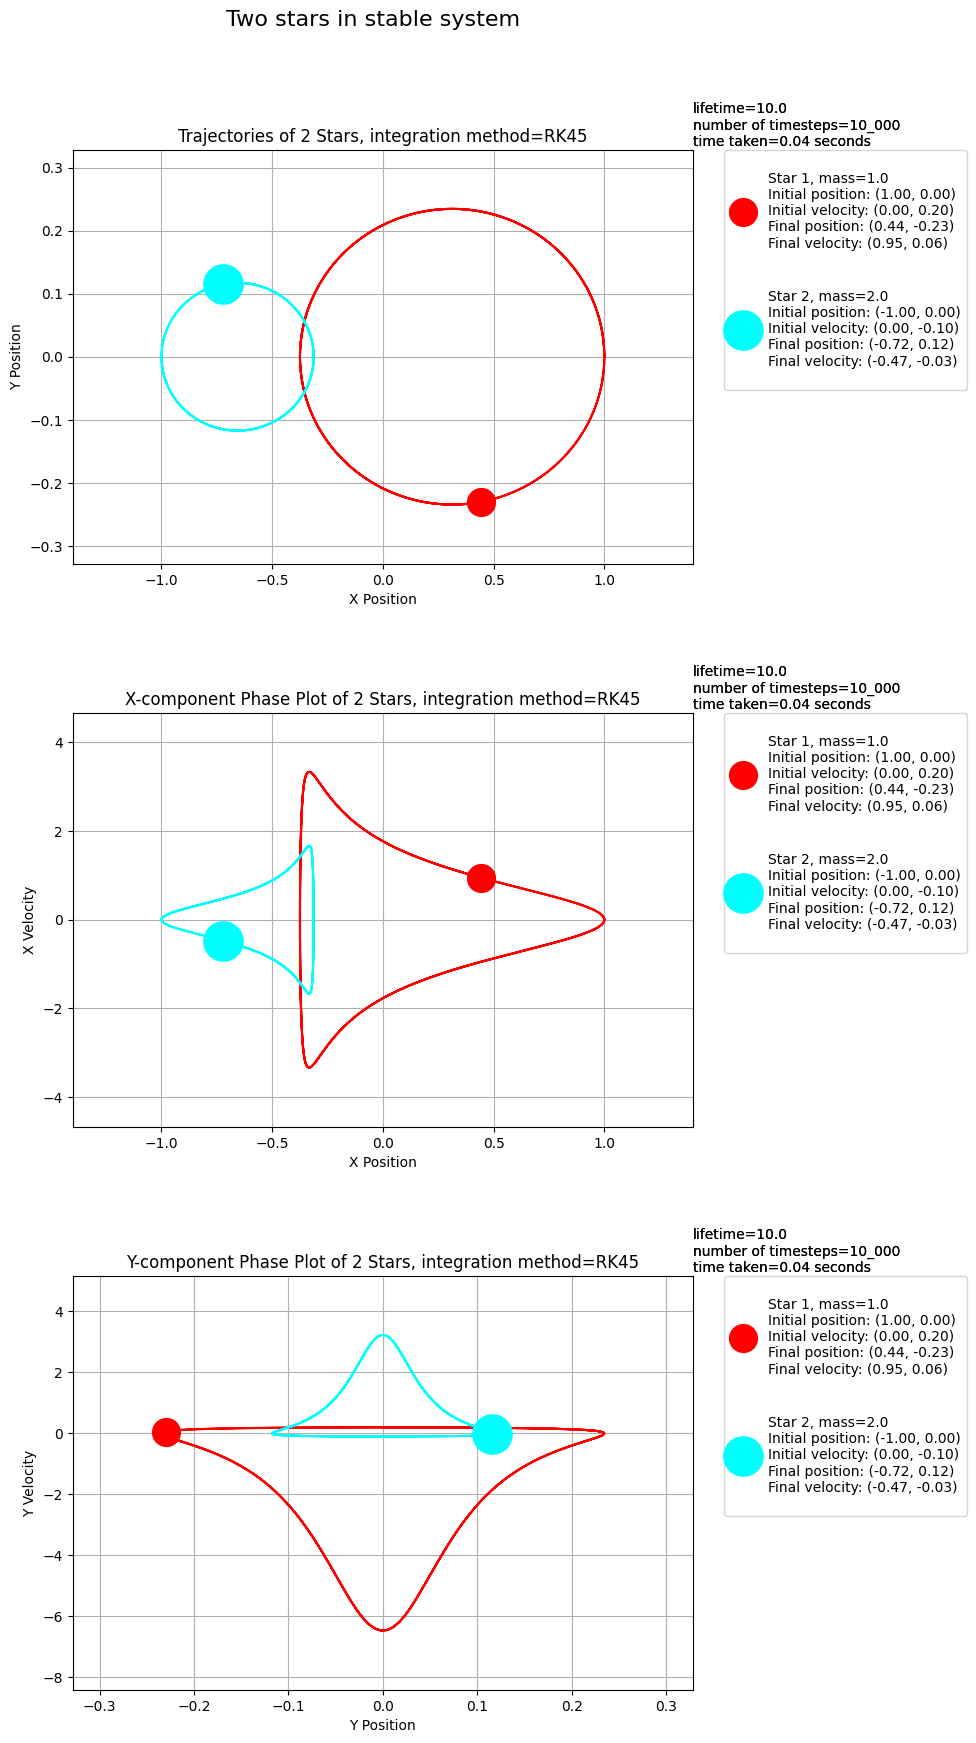

In [14]:
plot_scenario('2_stars_stable', 'RK45', lifetime=10.0, N_timesteps=10_000)

Let's try the simulation with the same initial conditions but with the midpoint method instead.

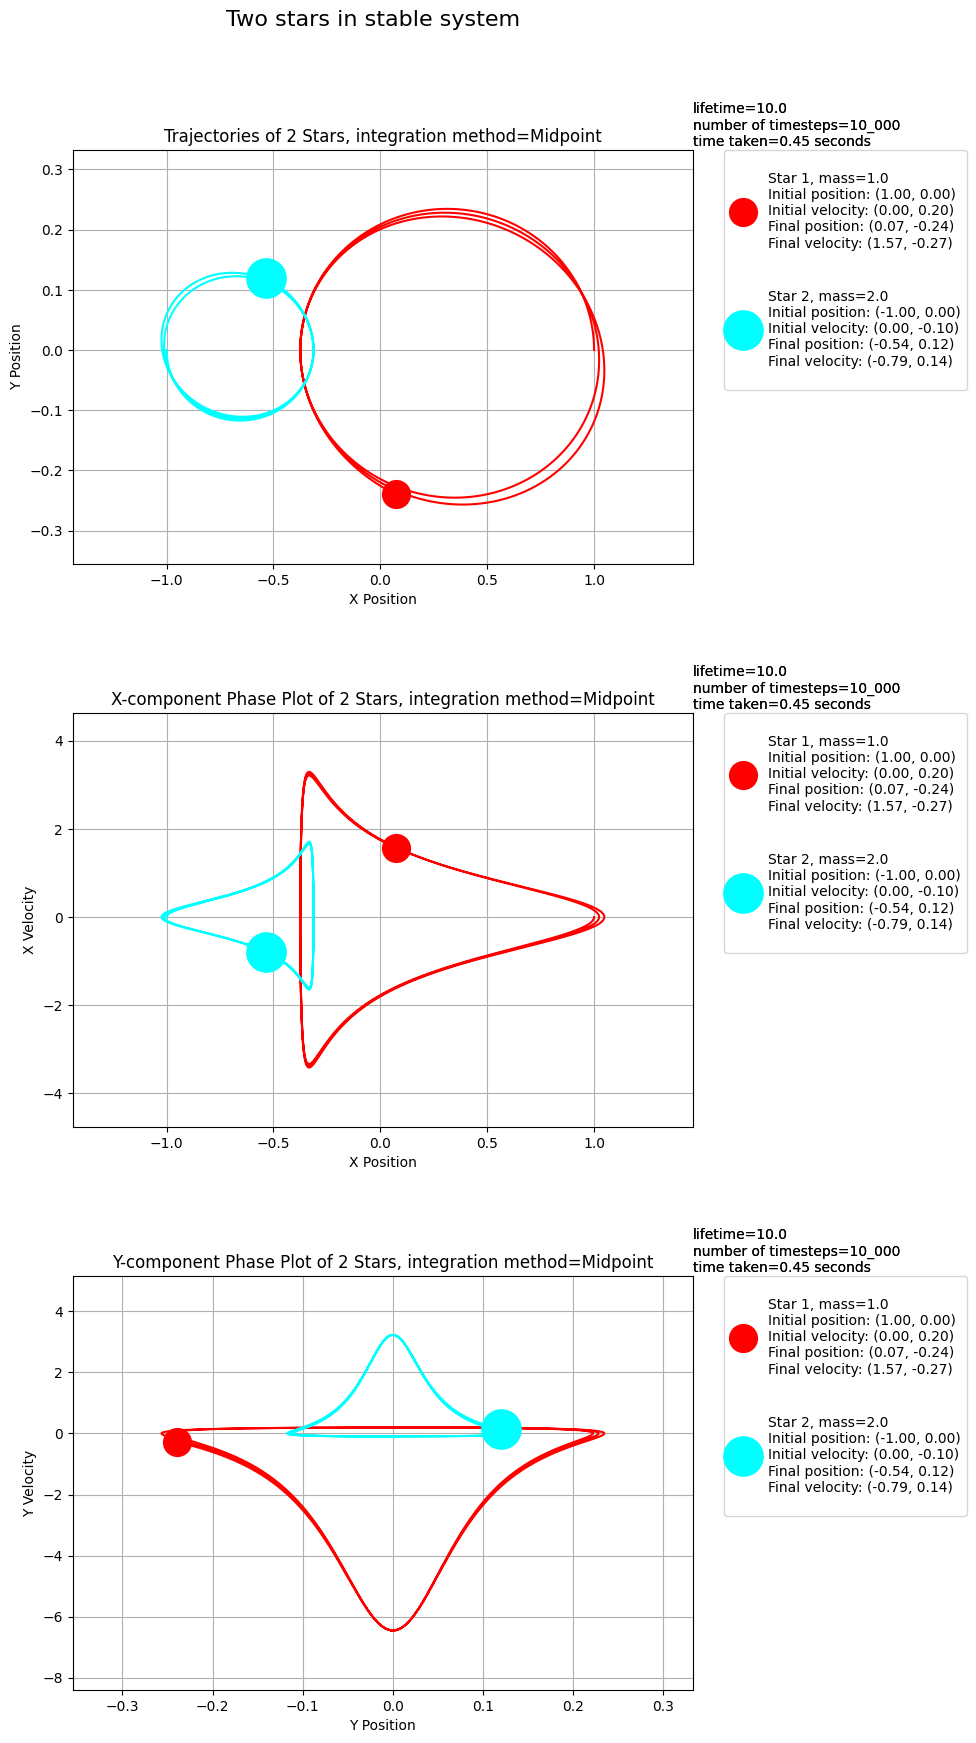

In [15]:
plot_scenario('2_stars_stable', 'Midpoint', lifetime=10.0, N_timesteps=10_000)

The midpoint method started to diverge a lot sooner. Let's try again with more timesteps ($100,000$), i.e. smaller step size $\Delta t$.

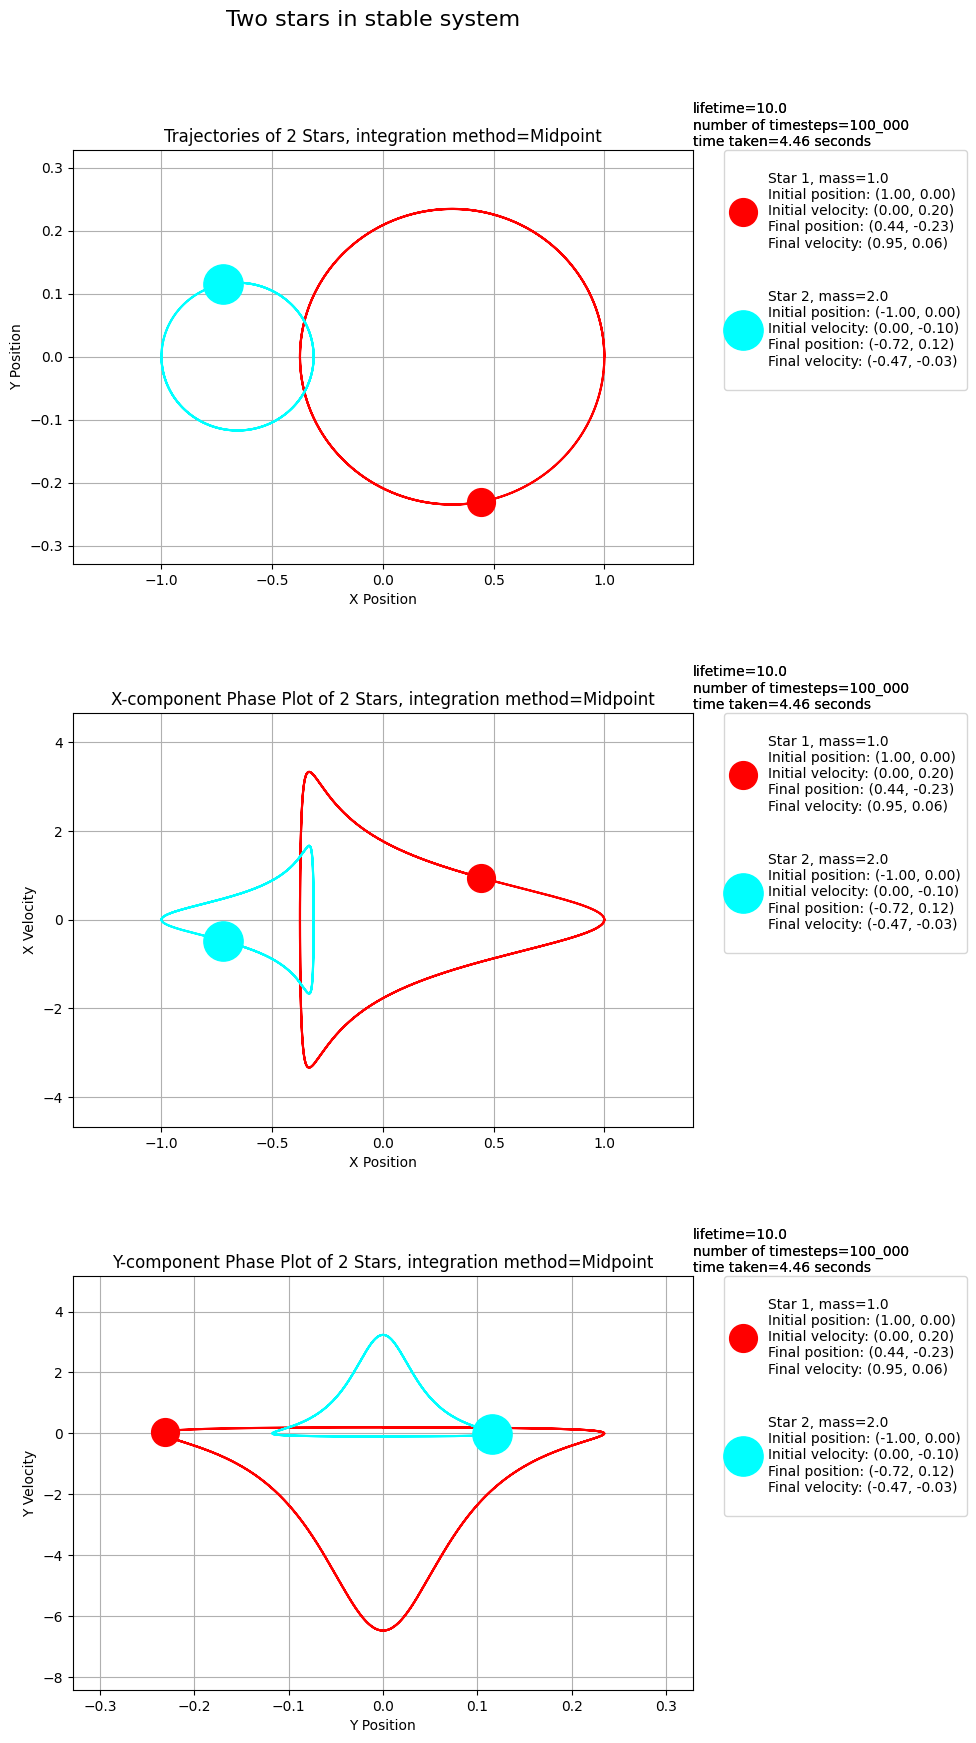

In [16]:
plot_scenario('2_stars_stable', 'Midpoint', lifetime=10.0, N_timesteps=100_000)

This is a much better result. However the time taken to run the simulation has also increased significantly. Here we increase the number of steps by $10$ times, and the time taken increase by $10$ times as well, so the runtime scales linearly with the number of steps.

We can expect the same behaviour if we try both integration methods for the other prepared scenarios. For the same number of steps and the same $\Delta t$, the midpoint method performs worse than the RK45 method implemented in `solve_ivp`. If we increase the number of steps or decrease $\Delta t$, the accuracy of the midpoint method should improve to a certain point. Note that if the $\Delta t$ is too small, it might lead to numerical instabilities.

For now, let's stick to the RK45 method for the rest of the simulations for the sake of both accuracy and runtime.

<a id="two-body-stationary"></a>
#### Two-body unstable system - stationary start and collision

Next, we have two stars with initial conditions at stationary. For simplicity, they are both on the x-axis with star 1 at $(1, 0)$ and star 2 at $(-1, 0)$. Their velocities are both zero at time $t=0$. The expected result is that they will be attracted to each other and collide.

/var/folders/93/vbctx38s679csjc40t_hlf5c0000gn/T/ipykernel_39704/998286529.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axis.set_ylim(vertical_min, vertical_max)
/var/folders/93/vbctx38s679csjc40t_hlf5c0000gn/T/ipykernel_39704/998286529.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axis.set_xlim(horizontal_min, horizontal_max)


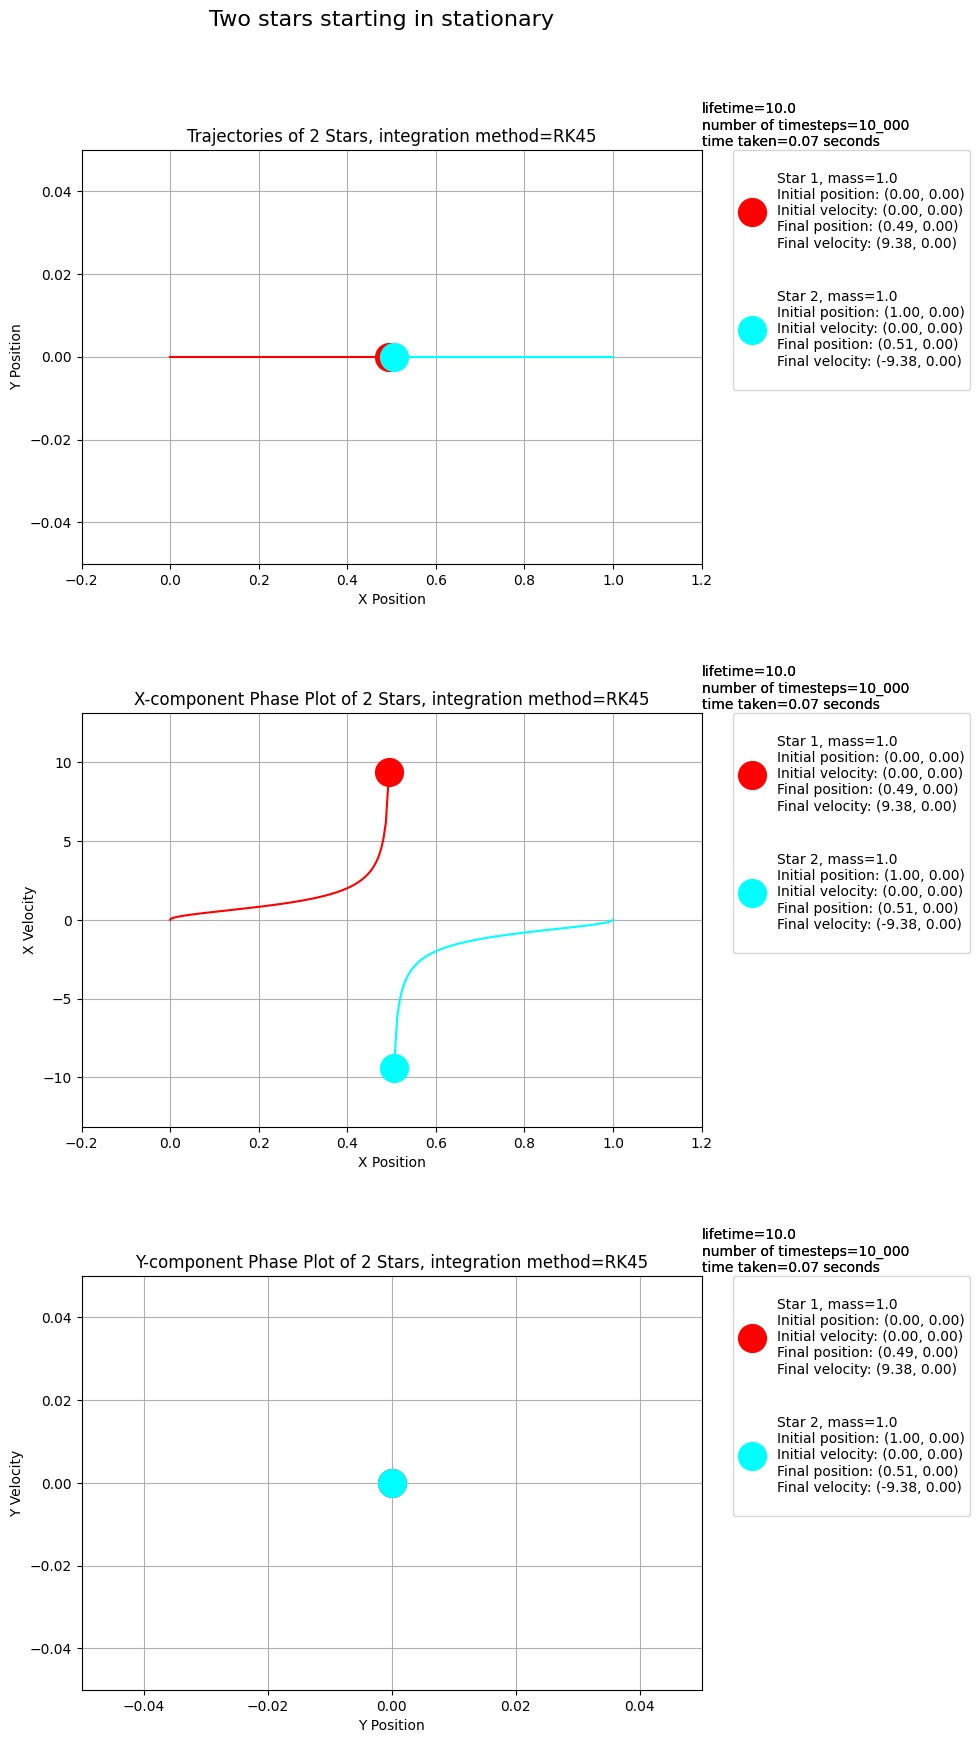

In [17]:
plot_scenario('2_stars_stationary', 'RK45', lifetime=10.0, N_timesteps=10_000)
# Note there might be some UserWarning's. This is because the y limits are too close
# to each other (both are 0) so `matplotlib` will automactically increase the y limits.

<a id='two-body-collide-nonlinear'></a>

#### Two-body unstable system with collision after non-linear motion

Two stars can also collide after some non-linear motion.

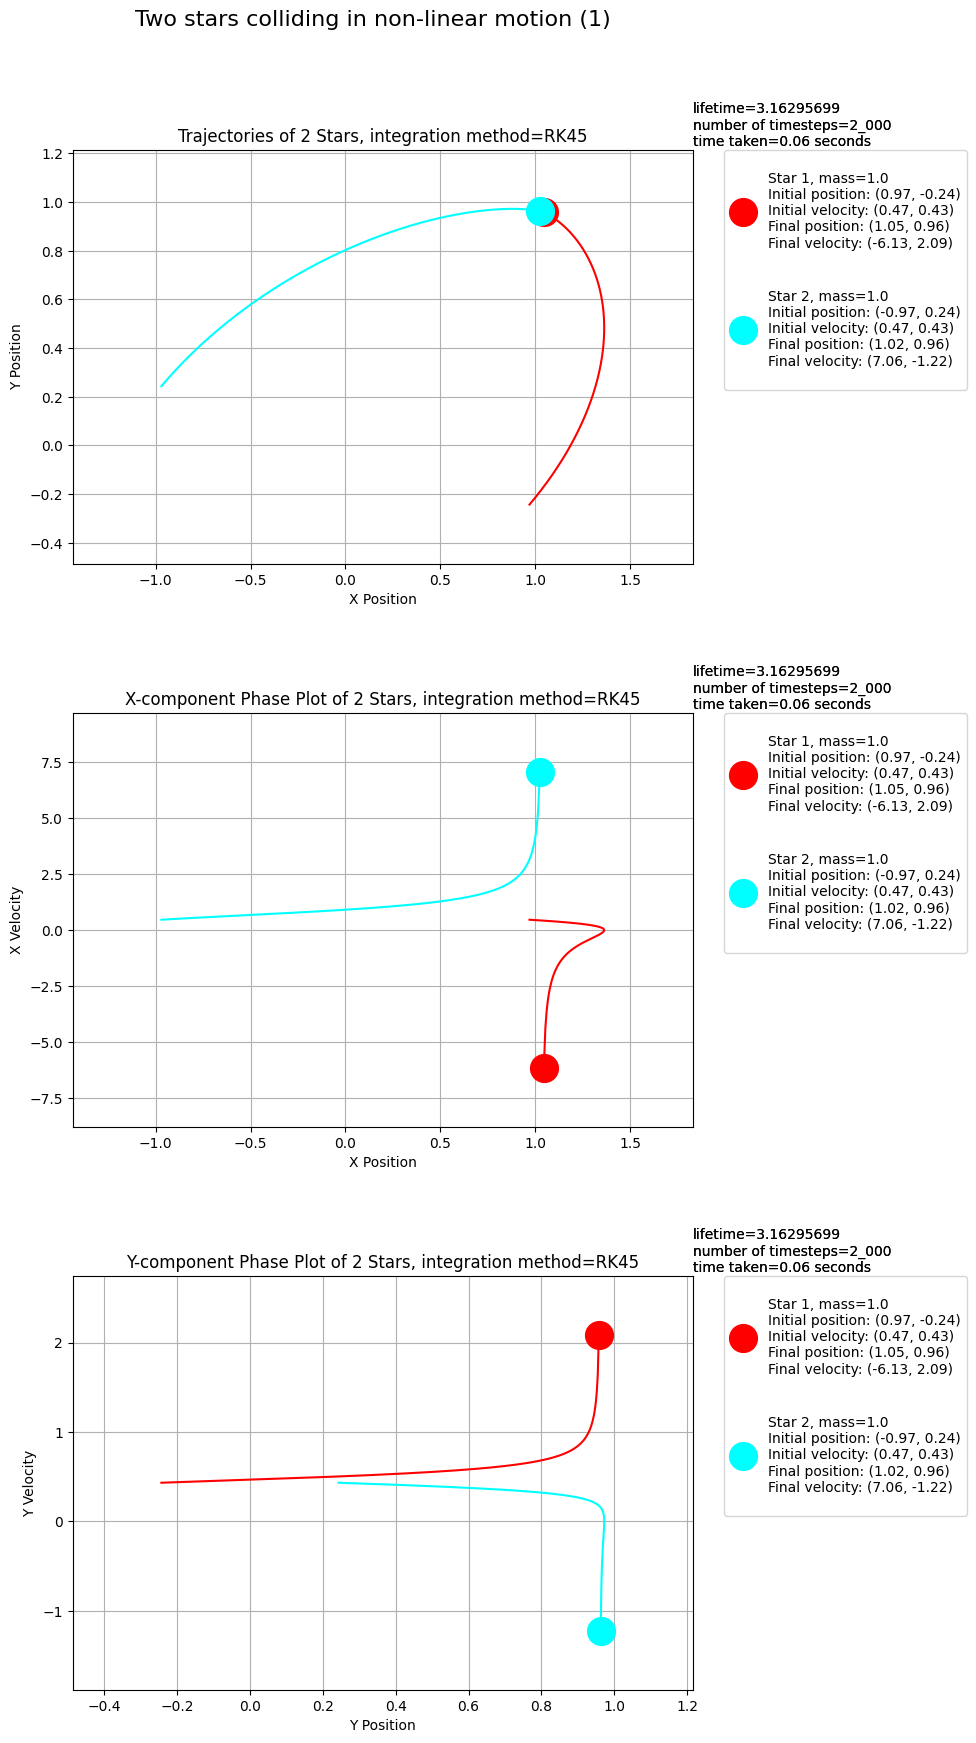

In [18]:
plot_scenario('2_stars_collide_nonlinear_1')

This is another kind of unstable two-body system collision where the two stars spiral inwards.

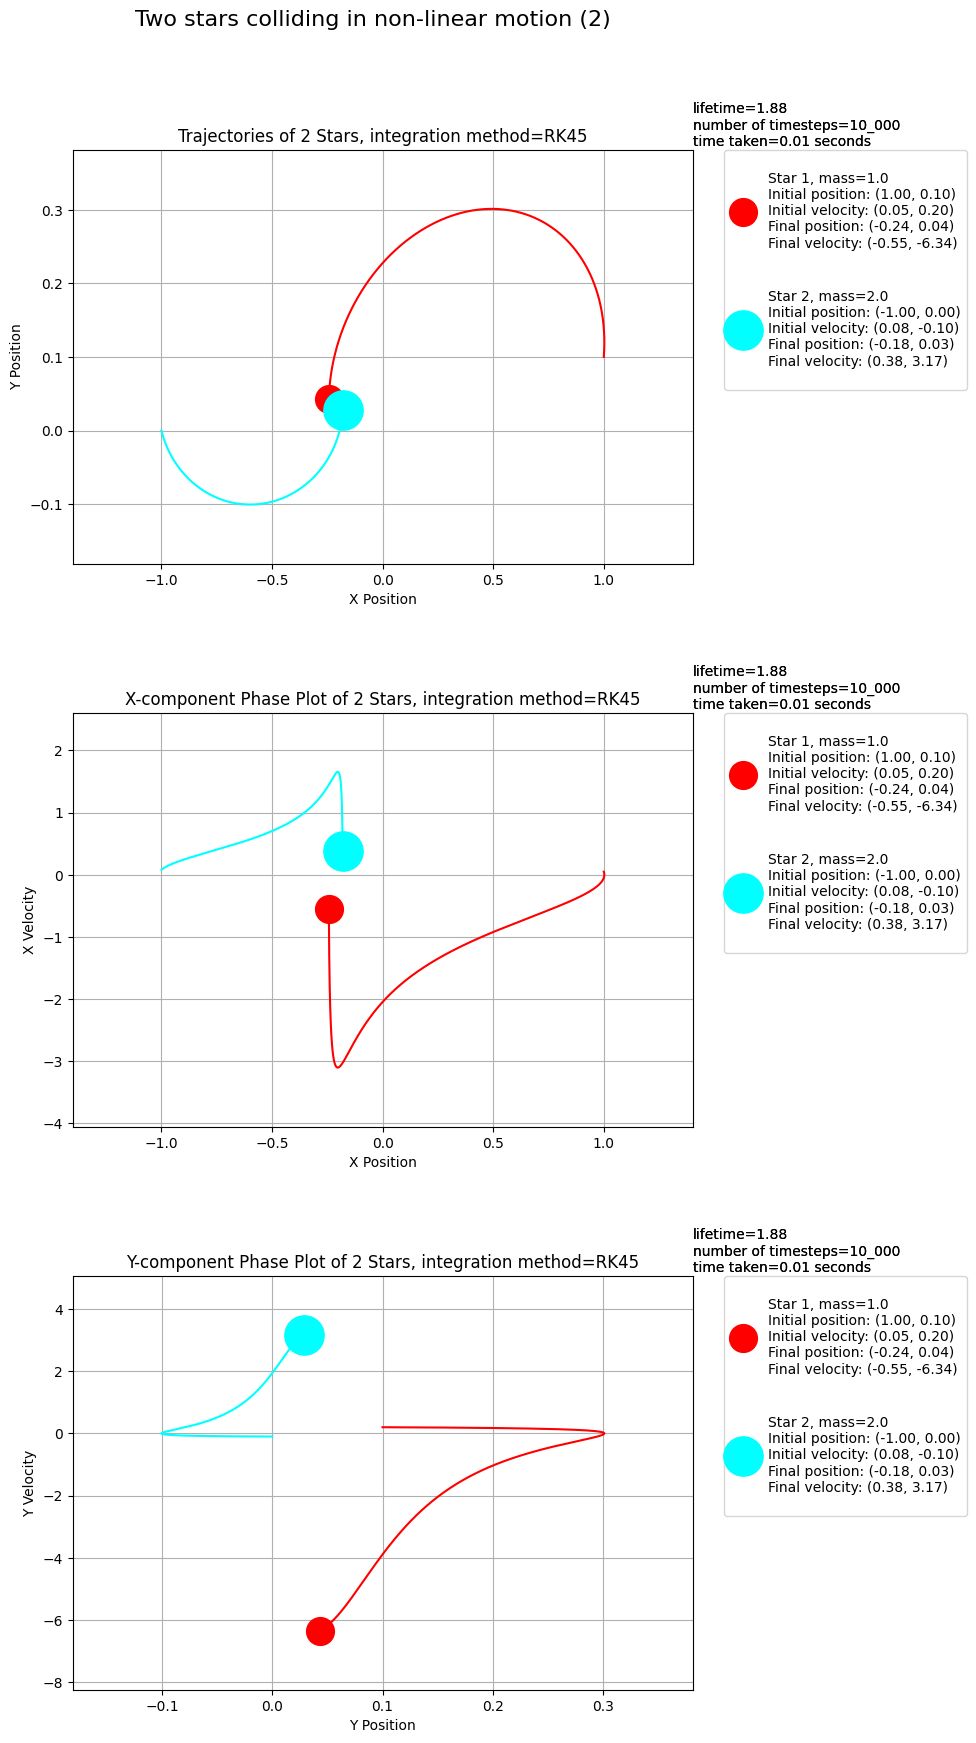

In [19]:
plot_scenario('2_stars_collide_nonlinear_2', 'RK45', lifetime=1.88, N_timesteps=10_000)

Another imaginable kind of unstable two-body systems is where two stars do not move in closed orbits but never collide. I have tried a number of sets of initial conditions but none have produced such a system.

<a id="three-body-system"></a>
### Three-Body System Simulation

<a id="three-body-stable"></a>
#### Three-body system with stable figure-8 orbit

Let's start with the most interesting three-body system! The initial conditions for the three-body system with stable figure-8 orbit are taken from [this paper](https://arxiv.org/abs/math/0011268) by Alain Chenciner and Richard Montgomery. The initial conditions are as follows:
- $m_1 = m_2 = m_3 = 1$
- $x_1 = -0.97000436, y_1 = 0.24308753, x_2 = 0.97000436, y_2 = -0.24308753, x_3 = 0, y_3 = 0$
- $v_{x_1} = v_{x_2} = v_{x_3} = 0, v_{y_1} = -0.466203685, v_{y_2} = -0.466203685, v_{y_3} = 0.93240737$
- period $\bar{T} = 12T = 6.32591398$


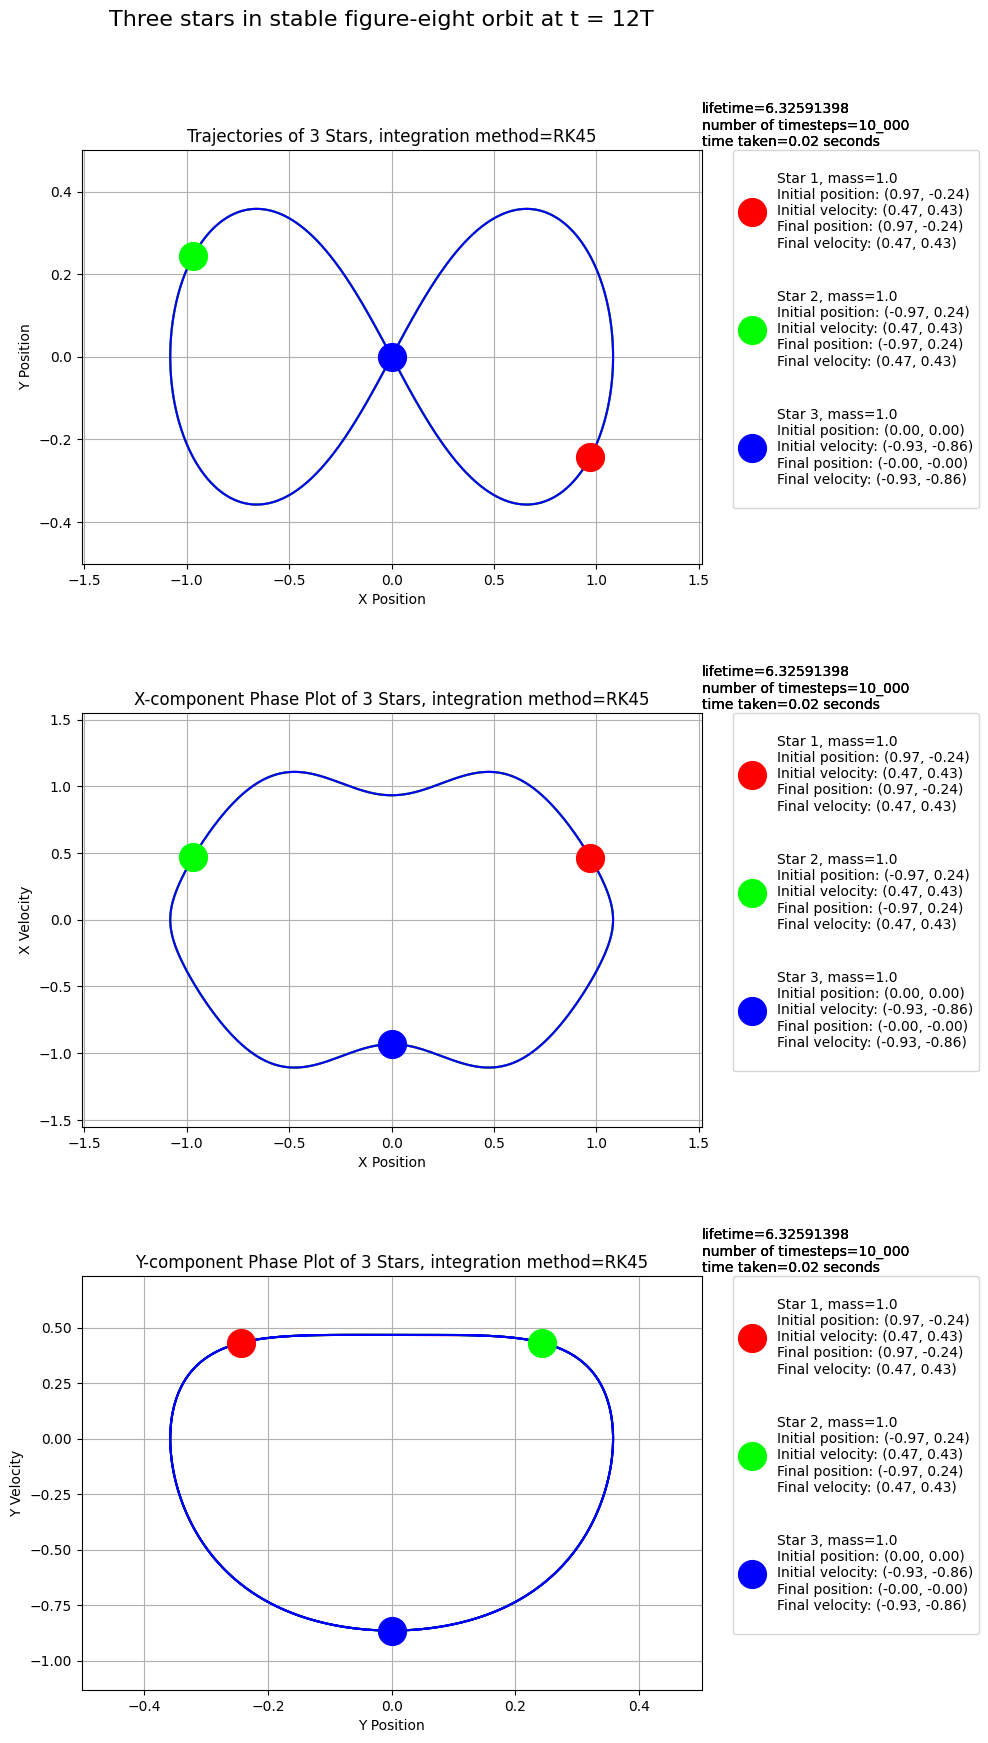

In [20]:
T_bar = 6.32591398   # T_bar = 12 * T
# This will show the three stars when they have made one full revolution/orbit.
plot_scenario('3_stars_stable_12T', 'RK45', lifetime=T_bar, N_timesteps=10_000)

I have also prepared an animation for this scenario. If the video exists in the same folder, running the cell below should play the video. If not, please find the correct path to the video or simply skip this cell.

IMPORTANT: Please keep in mind that the accelerations of the stars might not be visualised accurately due to my implementation of the animation. In reality the velocities change constantly, making the stars go slower then faster and so on, whereas in this animation the stars seem to move in a constant speed. This is mainly for showing the direction of movement of the stars.

In [21]:
from IPython.display import HTML

# If the video is in the same directory as the notebook
video_path = '3-stars-stable.mp4'

# HTML to embed the video
HTML(f"""
<video width="640" height="1280" controls>
  <source src="{video_path}" type="video/mp4">
</video>
""")

WARNING! The cell below contains code that makes many plots and save them as images into local storage in order to create a video. Please don't run it unless you are sure you want to re-create the video or make a new one. The terminal command I used to join the images together afterwards looks like this:
`ffmpeg -framerate 30 -pattern_type glob -i 'frames/*.png' -c:v libx264 3-stars-stable.mp4` 

In [22]:
# N_frames = 300       # This will make a 10-second long video at 30 fps
# T_bar = 6.32591398   # The stars will make exactly one full revolution/orbit in the video

# for i in range(0, N_frames + 1):
#     lifetime = T_bar
#     if i != 0: lifetime += T_bar / (N_frames / i)
#     plot_scenario('3_stars_stable_T', 'RK45', lifetime=lifetime, N_timesteps=30000 + 100 * i,
#                   is_plotting=False, filename=f'frames/3-stars-stable-{i:06d}.png')

Another kind of possible stable three-body systems is the one with three stars of equal masses starting from positions that make an equilateral triangle and with initial velocities on the tangent of the circle that passes through the three stars. This is not yet implemented in this project.

<a id='three-body-unstable'></a>
#### Three-body unstable system

The initial conditions for the three-body system with stable orbits are very difficult to find. If we change the initial conditions even a little bit, they will no longer make a stable system. Let's change just the masses of the stars for (1, 1, 1) to (0.8, 1, 1.2) as in the hypergiant scenario. Let's visualise the simulation.

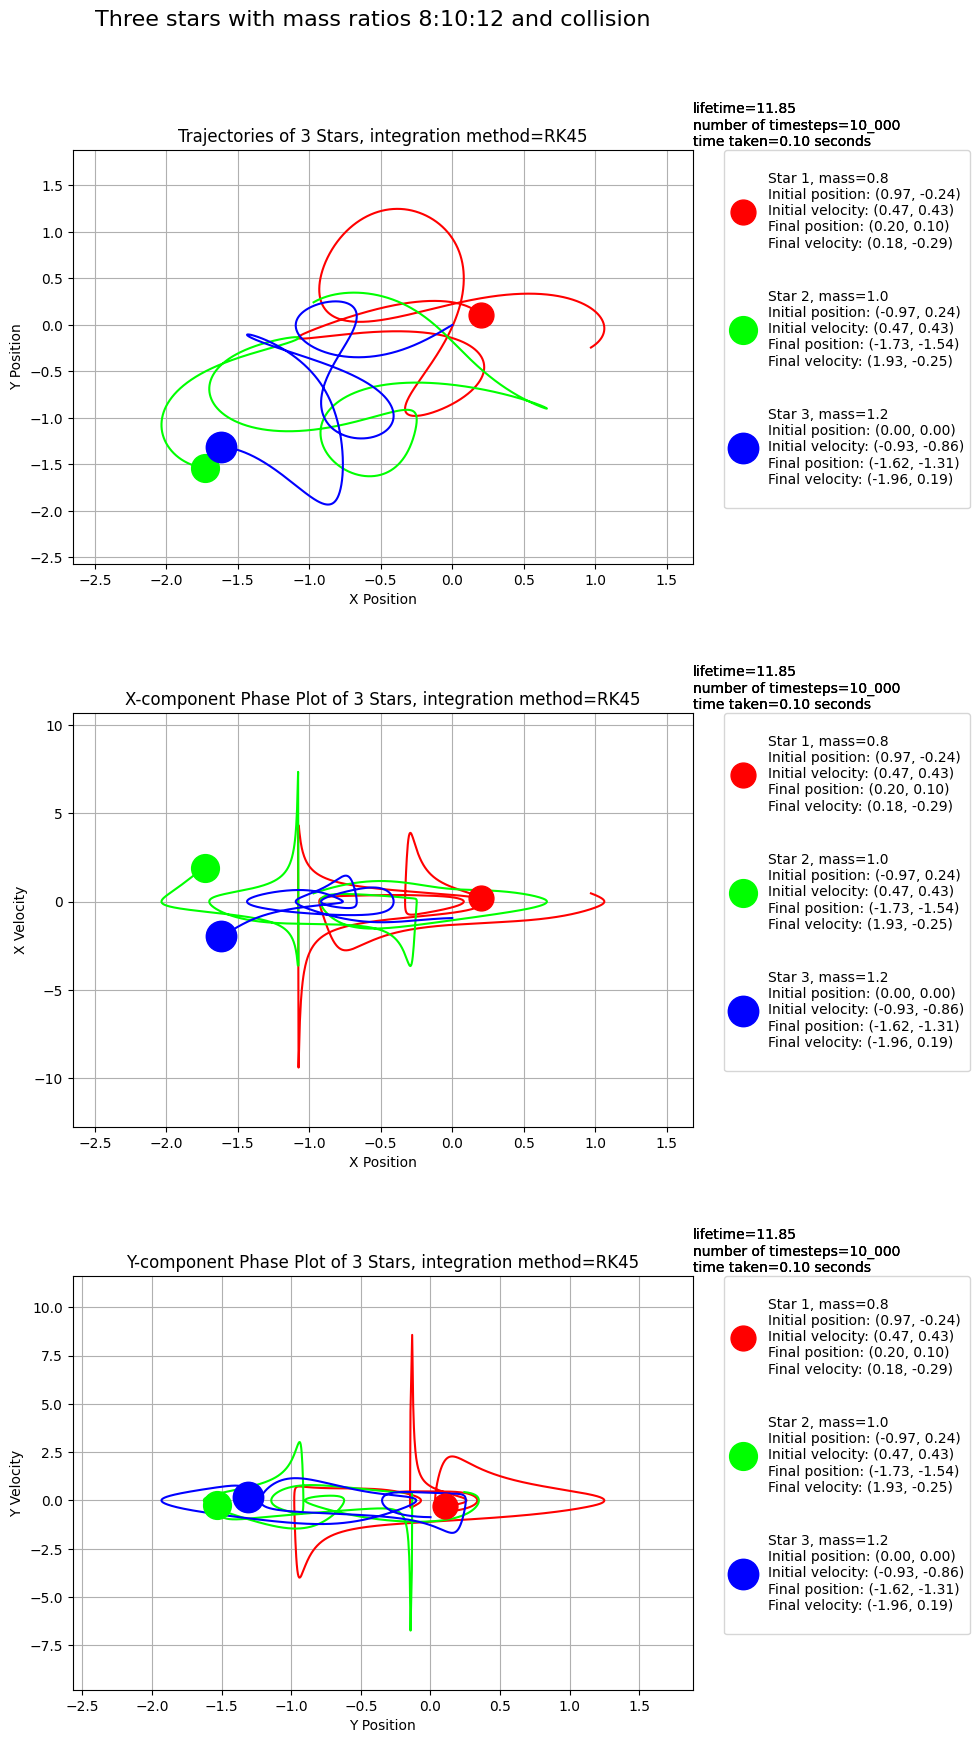

In [23]:
T_bar = 6.32591398
plot_scenario('3_stars_different_masses_unstable', 'RK45', lifetime=11.85, N_timesteps=10_000)

As we can see, the stable structure is completely gone. This is also an interesting configuration. We can see that stars 2 and 3 collide, which can be used as an example for the collision simulation.

If we change some other initial conditions, we might get a different result, such as a star being ejected from the system. The plot below is an example of such a system. Here star 1 is repelled and starts to move far away from the other two.

If we run the previous simulation long enough, one of the stars will also eventually be ejected from the system.

Note that here we assume stars act like points so they don't collide and simply pass through one another.

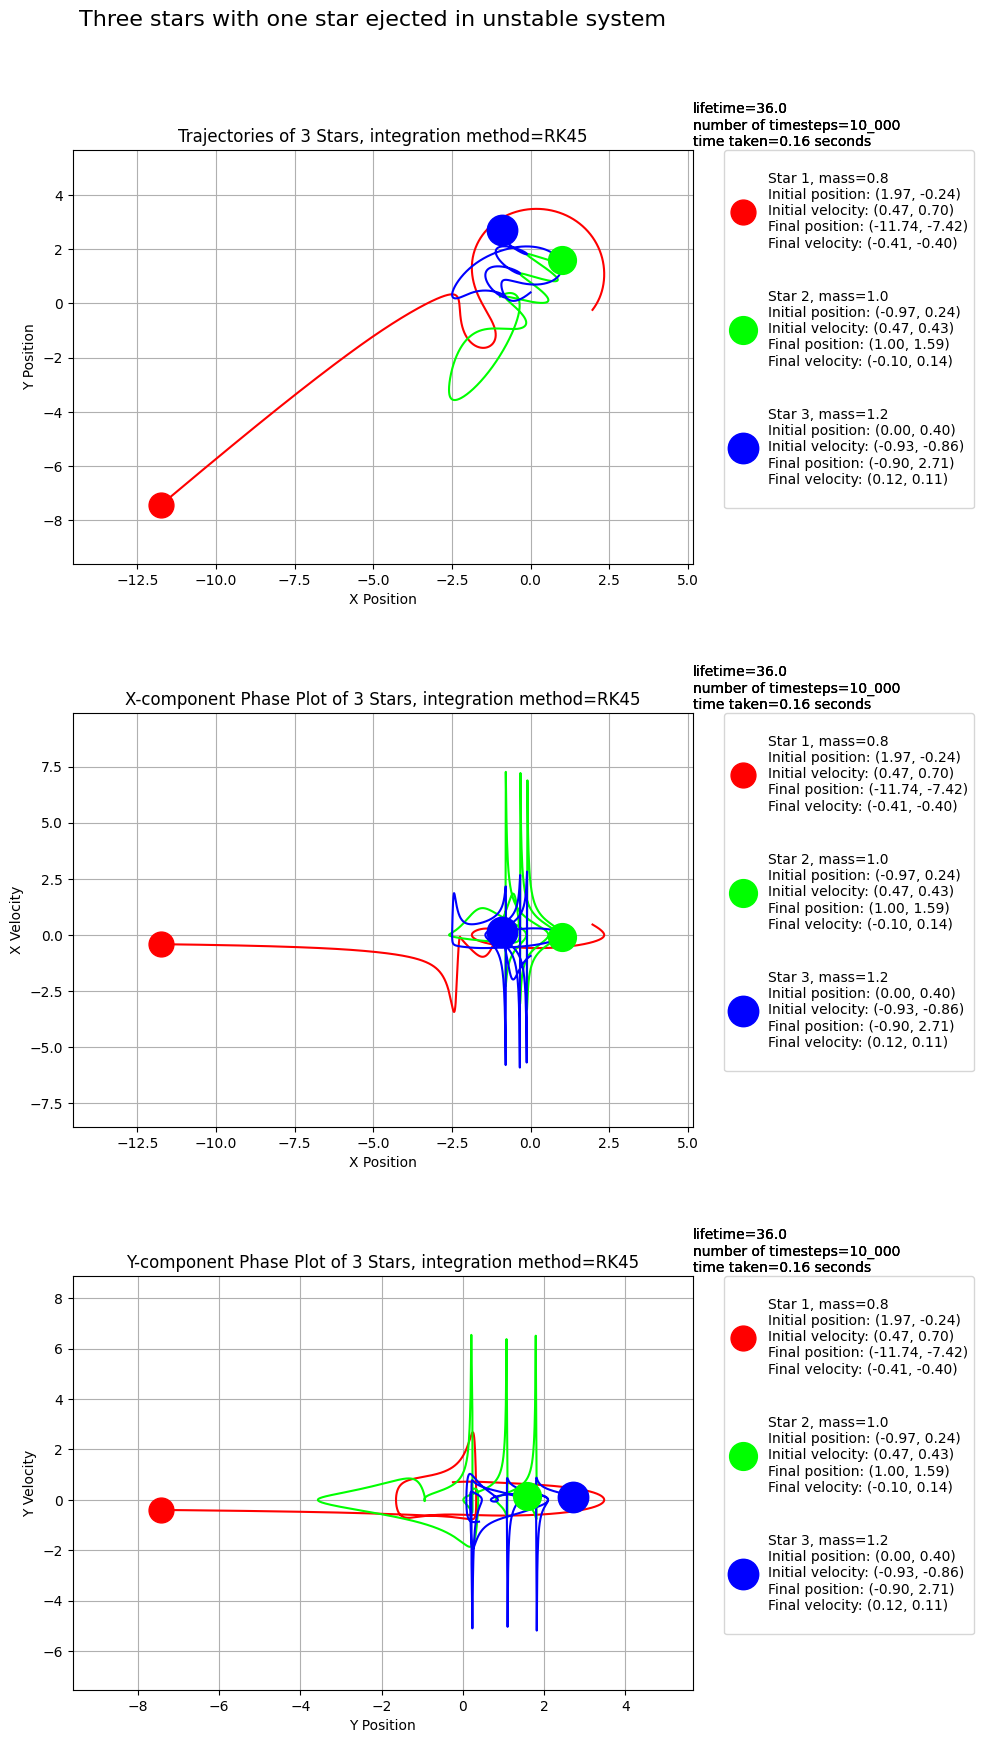

In [24]:
plot_scenario('3_stars_unstable_1_star_ejected', 'RK45', lifetime=36.0, N_timesteps=10_000)

<a id='four-body-system'></a>
### Four-body system

The last simulation will be only for demonstration purposes of the generalisability of the code. Let's simulate some simple four-body unstable systems.

<a id='four-body-collide'></a>
#### Four-body system with collision

This is a simple four-body system with four stars colliding into one another.

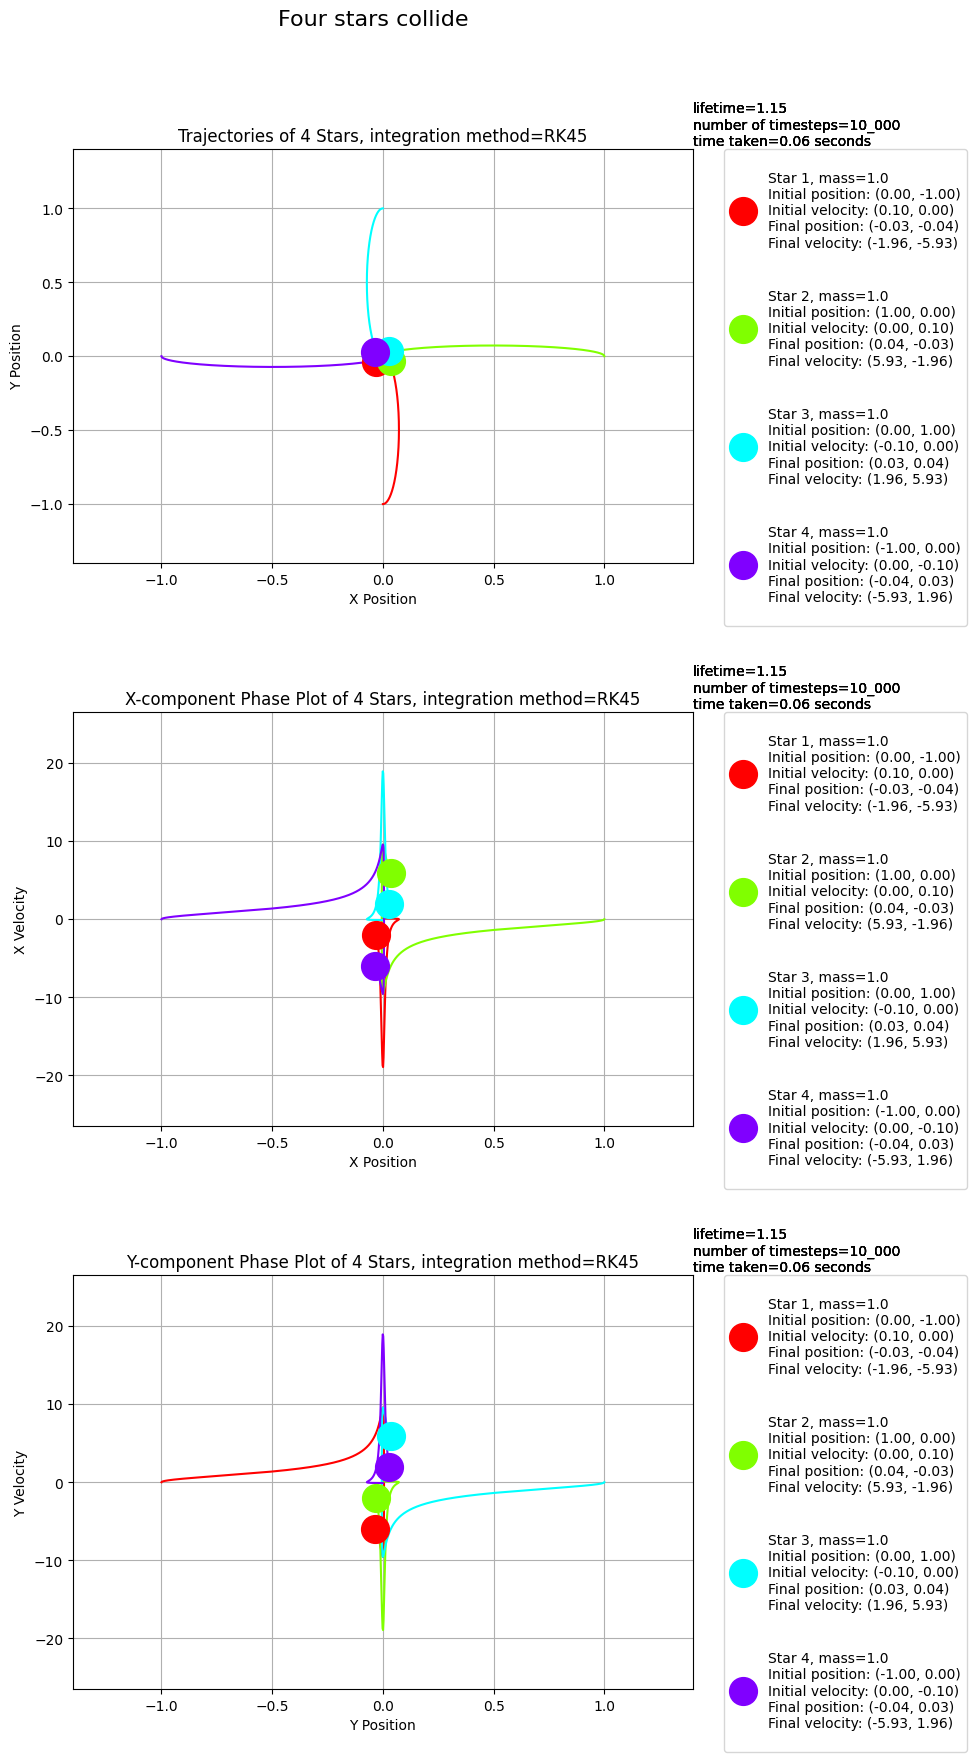

In [25]:
plot_scenario('4_stars_collide', 'RK45', lifetime=1.15, N_timesteps=10_000)

If we make the stars small enough or pretend that stars pass through one another, it seems like they could become a stable system.

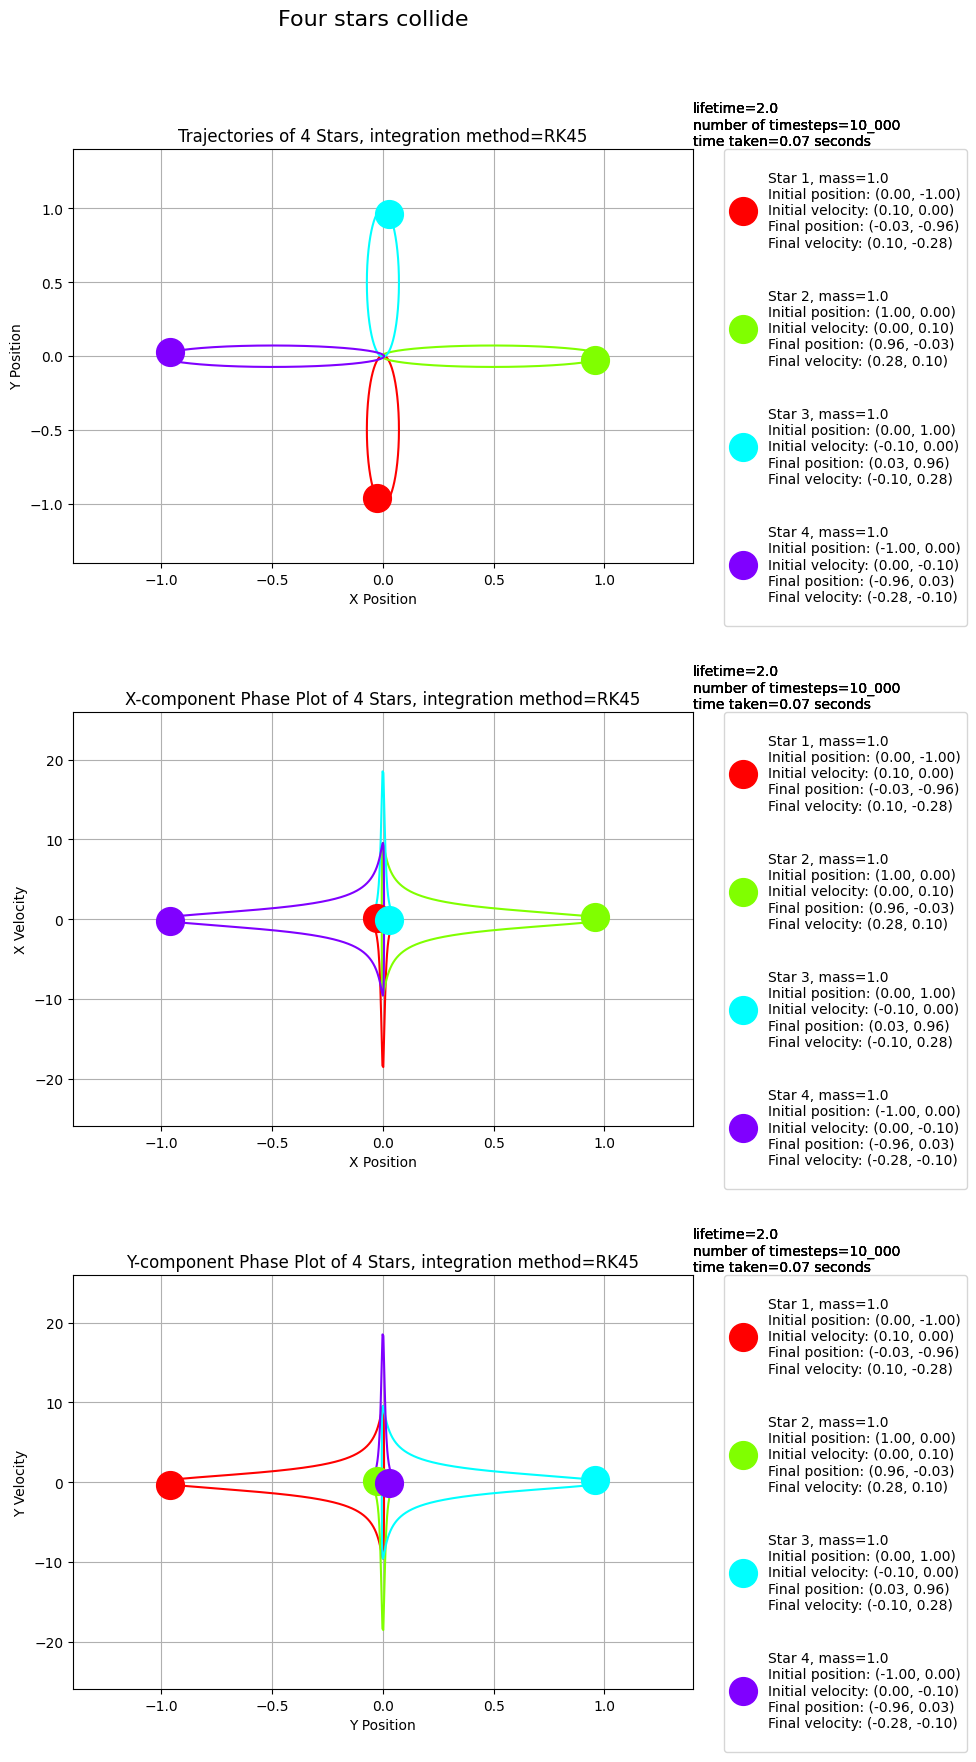

In [26]:
plot_scenario('4_stars_collide', 'RK45', lifetime=2.0, N_timesteps=10_000)

<a id='four-body-unstable'></a>
#### Four-body unstable system

This is a simple four-body system with absolutely no stable structure. The stars are moving in a chaotic manner.

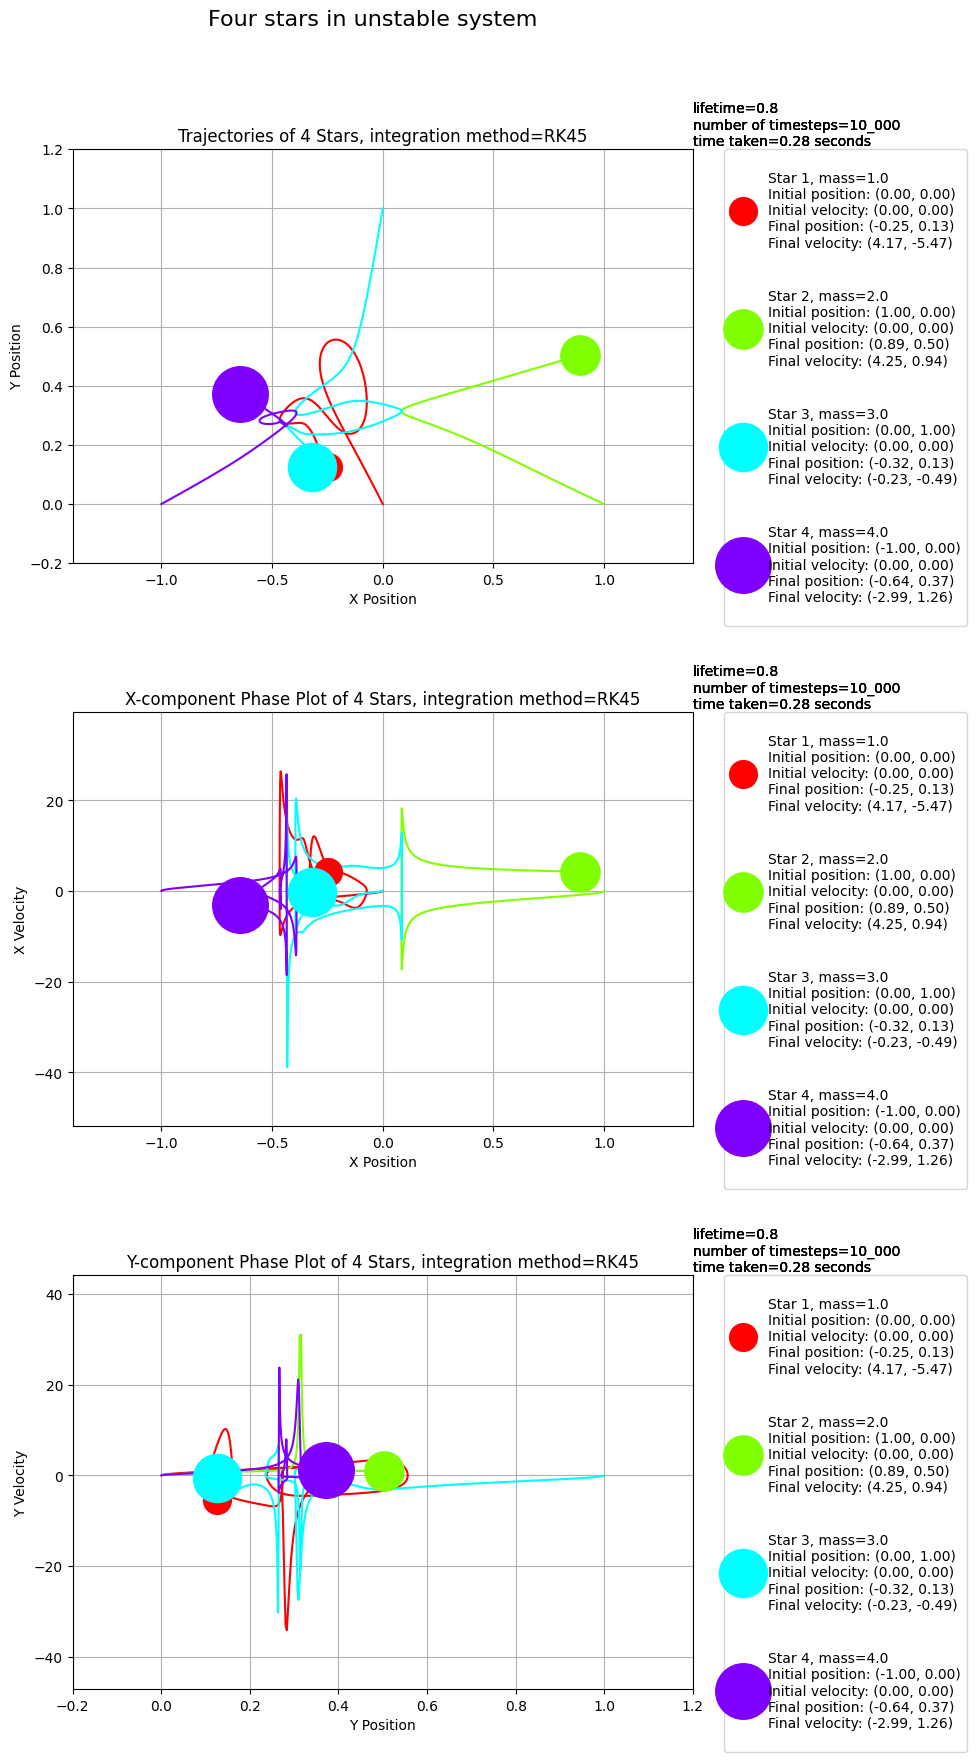

In [27]:
plot_scenario('4_stars_unstable', 'RK45', lifetime=0.8, N_timesteps=10_000)

Those are some static plots for different simulations. Let's try an interactive plot. This kind of plots helps make it easier to quickly experiment with different initial conditions to find interesting results.

<a id='interactive-plotting'></a>
### Interactive Plotting

Interactive plotting helps make exploring parameters easier. Below are some utility functions for interactive plotting. Please feel free to skip some of it and go to the actual plot.

#### Generate Textboxes

Textboxes are for the user to input initial conditions for the simulation.

In [28]:
# Just a small function to create a textbox with pre-defined formatting
def create_textbox(value, description):
  return widgets.Text(value=str(value), description=description,
    # increase the width of the label and textbox so that it is easier to read
    layout=widgets.Layout(width='600px'),
    style={'description_width': '300px'},
  )

# Create interactive textboxes
def create_textboxes(stars, lifetime, N_timesteps):
    textboxes_to_input_mass = []
    for (i_star, star) in enumerate(stars):
        textboxes_to_input_mass.append(create_textbox(star.mass, f'Star {i_star+1} Mass:'))
    star_textboxes = []
    for (i_star, star) in enumerate(stars):
        star_textboxes.append(create_textbox(star.x, f'Star {i_star+1} X:'))
        star_textboxes.append(create_textbox(star.y, f'Star {i_star+1} Y:'))
        star_textboxes.append(create_textbox(star.vx, f'Star {i_star+1} VX:'))
        star_textboxes.append(create_textbox(star.vy, f'Star {i_star+1} VY:'))

    # textboxes_to_input_mass = [gen_textbox(masses[i], f'Star {i+1} Mass:') for i in range(len(masses))]

    lifetime_textbox = create_textbox(lifetime, 'Simulation Time (arbitrary time unit):')
    N_timesteps_textbox = create_textbox(N_timesteps, 'Number of Steps:')
    return textboxes_to_input_mass, star_textboxes, lifetime_textbox, N_timesteps_textbox

#### Put the text boxes into a dictionary of arguments

So that I can dynamically create the text boxes as the number of stars changes.

In [29]:
def pack_widgets_into_arguments_dict(textboxes_to_input_mass, star_textboxes, lifetime_textbox, N_timesteps_textbox):
    # Prepare a dictionary of arguments to pass to the interactive display

    arguments = {}

    # arguments.update({
    #     'Initial conditions' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    # })

    # arguments.update({
    #     'Number of stars' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    # })

    arguments.update({
        'Masses' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    })

    arguments.update({
        f'init_mass{i+1}': textbox_to_input_mass for (i, textbox_to_input_mass) in enumerate(textboxes_to_input_mass)
    })

    arguments.update({
        'X coordinates' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    })

    arguments.update({
        f'init_x{i+1}': star_textboxes[i * 4] for i in range(len(star_textboxes) // 4)
    })

    arguments.update({
        'Y coordinates' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    })


    arguments.update({
        f'init_y{i+1}': star_textboxes[i * 4 + 1] for i in range(len(star_textboxes) // 4)
    })

    arguments.update({
        'VX velocities' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    })

    arguments.update({
        f'init_vx{i+1}': star_textboxes[i * 4 + 2] for i in range(len(star_textboxes) // 4)
    })

    arguments.update({
        'VY velocities' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    })

    arguments.update({
        f'init_vy{i+1}': star_textboxes[i * 4 + 3] for i in range(len(star_textboxes) // 4)
    })

    arguments.update({
        'Simulation parameters' : widgets.HTML(value='<hr>', style={'description_width': '150px'})
    })

    # Add other arguments
    arguments['t_span'] = lifetime_textbox
    arguments['t_steps'] = N_timesteps_textbox

    # Create a RadioButtons widget
    radio_buttons = widgets.RadioButtons(
        options=['RK45', 'Midpoint'],
        description='Explicit integration method:',
        disabled=False,
        # increase the width of the label so that it is easier to read
        layout=widgets.Layout(width='600px'),
        style={'description_width': '300px'},
    )

    arguments['integration_method'] = radio_buttons

    return arguments

#### Create interactive plot

In [30]:
from IPython.display import display, HTML

# This should help show the whole interactive plot instead of
#   showing only a small part in a scrollable element
display(HTML("""
<style>
.output_scroll {
    height: auto !important;
}
</style>
"""))

In [31]:
def run_interactive_simulation(initial_masses, initial_x_coords, initial_y_coords, initial_vx_vels, initial_vy_vels,
                              initial_lifetime, initial_N_timesteps, initial_integration_method, scenario_title='Interactive N-Body Simulation'):
    # Create an Output widget to display the plot
    output_widget = Output()

    N_stars = len(initial_masses)
    stars_in_initial_state = [
        Star(mass=initial_masses[i],
            position_vector=np.array([initial_x_coords[i], initial_y_coords[i]]),
            velocity_vector=np.array([initial_vx_vels[i], initial_vy_vels[i]])
        ) for i in range(len(initial_masses))
    ]

    textboxes_to_input_mass, star_textboxes, lifetime_textbox, N_timesteps_textbox = create_textboxes(
        stars_in_initial_state, lifetime=initial_lifetime, N_timesteps=initial_N_timesteps
    )

    # Create a function to update the plot when textboxes are changed. To be used in `interactive`
    def update_plot(**kwargs):
        try:
            masses = [float(kwargs.get(f'init_mass{i+1}', initial_masses[i])) for i in range(N_stars)]
            lifetime = float(kwargs.get('t_span', initial_lifetime))
            N_timesteps = int(kwargs.get('t_steps', initial_N_timesteps))
            integration_method = kwargs.get('integration_method', initial_integration_method)
            initial_stars=[Star(
                mass=masses[i],
                position_vector=np.array([
                    float(kwargs.get(f'init_x{i+1}', initial_x_coords[i])),
                    float(kwargs.get(f'init_y{i+1}', initial_y_coords[i]))
                ]),
                velocity_vector=np.array([
                    float(kwargs.get(f'init_vx{i+1}', initial_vx_vels[i])),
                    float(kwargs.get(f'init_vy{i+1}', initial_vy_vels[i]))
                ])
            ) for i in range(N_stars)]

            system_of_stars = SystemOfStars(initial_stars=initial_stars)
            solution, timesteps, time_taken = system_of_stars.simulate_N_body_system(
                integration_method=integration_method,
                lifetime=lifetime,
                N_timesteps=N_timesteps,
            )
            Plotter.plot_graphs_onto_output_widget(
                output_widget=output_widget,
                scenario_title=scenario_title,
                masses=masses,
                sol=solution,
                lifetime=lifetime,
                N_timesteps=N_timesteps,
                integration_method=integration_method,
                time_taken=time_taken
            )
        except Exception as e:
            with output_widget:
                output_widget.clear_output(wait=True)
                print(f"Error: {e}")

    arguments = pack_widgets_into_arguments_dict(textboxes_to_input_mass, star_textboxes, lifetime_textbox, N_timesteps_textbox)

    # Create the interactive plot
    interactive_plot = interactive(update_plot, **arguments)

    # Display the interactive widget
    display(interactive_plot)

    # Display the Output widget containing the plot
    display(output_widget)

    # NOTE:
    #   - It might take a few seconds for the plot to be updated after the textboxes are changed.
    #     During that time it will appear as if nothing is happening.
    #     This is because the system of differential equations is being solved again.
    #   - Sometimes the plot is duplicated.
    #     Restarting the kernel might not fix it.
    #     Please try to shut down Jupiter Notebook and restart it.


def example_interactive_plot():
    # Example with 3 stars in stable orbit
    scenario_3_body_stable_orbit = get_prepared_scenarios('3_stars_stable_12T')

    run_interactive_simulation(
        initial_masses=scenario_3_body_stable_orbit['masses'],
        initial_x_coords=scenario_3_body_stable_orbit['x_coords'],
        initial_y_coords=scenario_3_body_stable_orbit['y_coords'],
        initial_vx_vels=scenario_3_body_stable_orbit['vx_vels'],
        initial_vy_vels=scenario_3_body_stable_orbit['vy_vels'],

        initial_lifetime=scenario_3_body_stable_orbit['lifetime'],
        initial_N_timesteps=scenario_3_body_stable_orbit['N_timesteps'],
        initial_integration_method='RK45',
        scenario_title='Interactive Three-Body Simulation'
    )



example_interactive_plot()

interactive(children=(HTML(value='<hr>', description='Masses', style=DescriptionStyle(description_width='150px…

Output()

<a id='convergence-test'></a>
## Convergence Test
    
This section does a convergence test on the Midpoint method for the 3-body problem.

As we saw in the lecture, the Midpoint method is of second order, meaning that as the resolution doubles, the errors decrease by around four times.

First, let's design a function to execute a convergence test.

In [32]:
def test_convergence_and_plot(derivative_function, initial_state, integration_function,
                              get_values_to_compare_function, to_str_function,
                              expected_order=2.0, value_to_compare_name='y',
                              initial_N_steps : int=16, lifetime=DEFAULT_LIFETIME,
                              returns_string=False, filename=None):

    check_type_and_lowerbound(expected_order, 'Expected order', float, 1.0, strict=False)
    check_type_and_lowerbound(initial_N_steps, 'Initial number of steps to try', int, 1, strict=False)
    check_type_and_lowerbound(lifetime, 'Lifetime', float, 0.0, strict=True)

    N_steps_vector = [initial_N_steps, initial_N_steps * 2, initial_N_steps * 4]

    string = ''

    fig, ax = plt.subplots(2, 1, figsize=(6, 10))
    fig.subplots_adjust(hspace=0.28)
    ax_values = ax[0]
    ax_error = ax[1]

    delta_t_levels = ['High', 'Medium', 'Low']
    delta_t_values = [lifetime / N_steps for N_steps in N_steps_vector]

    def get_delta_t_string(isteps): return f'{delta_t_levels[isteps]} Δt={delta_t_values[isteps]}'

    for isteps, N_steps in enumerate(N_steps_vector) :
        timepoints = np.linspace(0, lifetime, N_steps + 1)
        solution = integration_function(derivative_function, initial_state,
                                        lifetime, timepoints)

        values_to_compare = get_values_to_compare_function(solution)
        assert len(values_to_compare) == len(timepoints),\
            f"len(values_to_compare)={len(values_to_compare)} != len(timepoints)={len(timepoints)}"

        # Extra plot for the solution to make sure we are doing what we expect to do...
        ax_values.plot(timepoints, values_to_compare,
            label=f"{get_delta_t_string(isteps)} ({N_steps} steps)",)

        if returns_string: string += '\n' + to_str_function(solution) + '\n'

        if isteps > 0 :
            # Need to take every other entry for the finer resolution
            # so the size of the vectors match
            diff = values_to_compare[::2] - old_values_to_compare

            ax_error.plot(
                timepoints[::2], diff,
                label=f'''Actual difference between
{get_delta_t_string(isteps-1)} and {get_delta_t_string(isteps)}''')

            if isteps == 1 :
                ax_error.plot(
                    timepoints[::2], diff / (2.0**expected_order), '--',
                    label=f'''Expected difference between
{get_delta_t_string(isteps)} and {get_delta_t_string(isteps+1)}''',)

                ax_error.annotate(
                    xy=(1.02, 0.5), xycoords='axes fraction', fontsize=8,
                    text=f'''
Expected error between {get_delta_t_string(isteps)} and {get_delta_t_string(isteps+1)} is calculated
by dividing the actual error between {get_delta_t_string(isteps-1)} and {get_delta_t_string(isteps)}
by {2.0**expected_order} since we are check for convergence of order {expected_order}.''',
                )

        old_values_to_compare = values_to_compare

    ax_values.grid()
    ax_values.legend(
        bbox_to_anchor=(1.0, 1.0),
        loc='upper left',
        borderaxespad=0.0,
    )
    ax_values.set_ylabel(value_to_compare_name)
    ax_values.set_xlabel("t")
    ax_values.set_title('Solutions with different Δt values', fontsize=11)

    ax_error.grid()
    ax_error.legend(
        bbox_to_anchor=(1.0, 1.0),
        loc='upper left',
        borderaxespad=0.0,
        handleheight=2.4,
    )
    ax_error.set_ylabel("Solution error")
    ax_error.set_xlabel("t")
    ax_error.set_title('Relative error between solutions with different Δt values', fontsize=11)

    fig.suptitle("Convergence test", y=0.95, fontsize=16, fontweight='bold', ha='center')
    plt.show();

    if filename is not None :
        fig.savefig(filename,
                    # dpi=300,
                    bbox_inches='tight')
    if returns_string: return string


Before using the function on the 3-body problem, let's double-check that the Midpoint method is indeed of second order. I will try to replicate the results from Activity 2 of Lab Exercises in Week 4.

In [33]:
def integrate_using_midpoint_Lab_Week_4(dydt, y0, lifetime, timepoints) :
    _y_solution = np.zeros_like(timepoints)
    for itime, time in enumerate(timepoints) :
        if itime == 0 :
            _y_solution[itime] = y0
            old_time = time
        else :
            _delta_t = time - old_time
            dydt_at_t = dydt(old_time, _y_solution[itime-1])

            y_t_plus_half = (_y_solution[itime-1] + 0.5 *
                                      dydt_at_t * _delta_t)

            t_plus_half = old_time + 0.5*_delta_t

            dydt_at_t_plus_half = dydt(t_plus_half, y_t_plus_half)

            _y_solution[itime] = (_y_solution[itime-1] +
                                      dydt_at_t_plus_half * _delta_t)
            old_time = time
    return _y_solution

To make sure that everything's alright, I use the same example in Activity 2 of Lab Exercises Week 4 and compare to the original output.

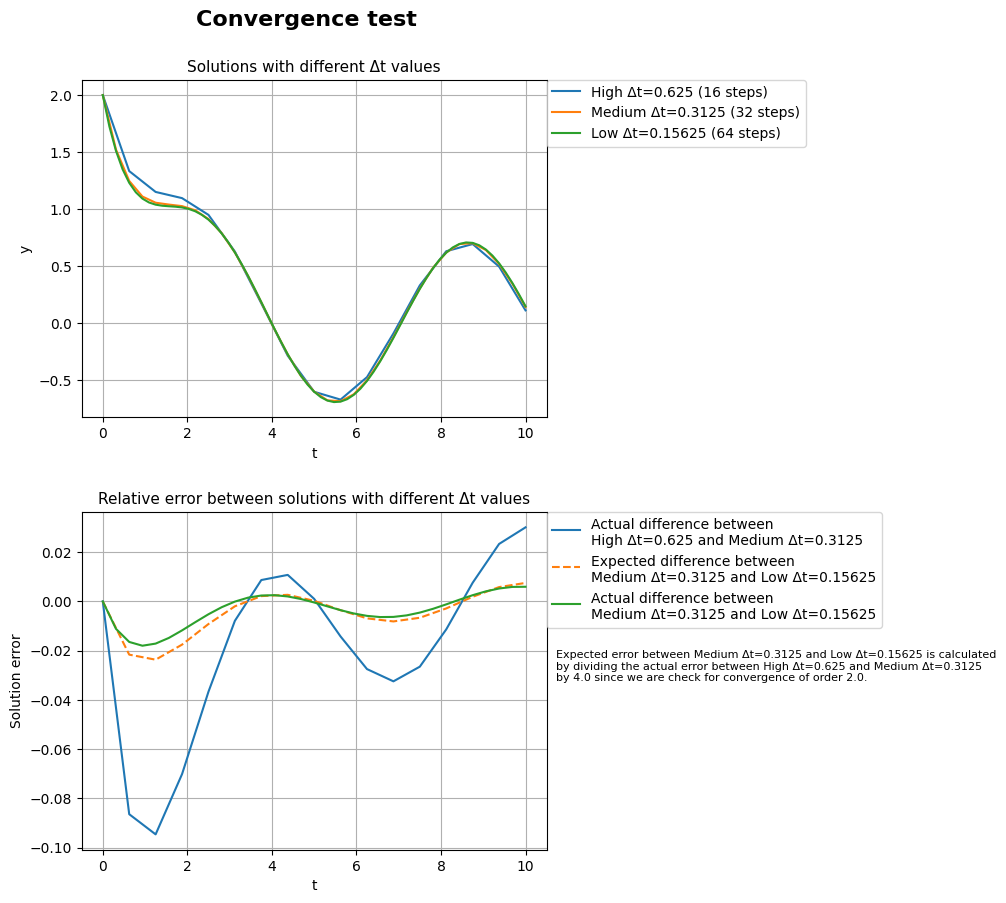

The convergence testing function works as expected.


In [34]:
# The decay function with a source that was used in Week 4 Lab, Activity 2
def calculate_dydt(t, y):
    dydt = - y + np.sin(t)
    return dydt

def example_convergence_test_from_week_4_lab(integration_function, get_values_to_compare_function, to_str_function):
    solution_str = test_convergence_and_plot(
        calculate_dydt,
        initial_state=np.array([2.0]),  # value used in Week 4 Lab, Activity 2
        integration_function=integration_function,
        get_values_to_compare_function=get_values_to_compare_function,
        to_str_function=to_str_function,
        expected_order=2.0,
        initial_N_steps=16,             # N_steps=16 is the value used in Week 4 Lab, Activity 2
        lifetime=10.0,                  # lifetime=10.0 is value used in Week 4 Lab, Activity 2
        returns_string=True,
    )

    # Check against expected output from Week 4 Lab, Activity 2
    expected_solution_str = '''
[ 2.          1.33277407  1.14962159  1.0952735   0.94817161  0.62585535
  0.1714376  -0.28818829 -0.6048626  -0.67346638 -0.47639306 -0.092902
  0.32930928  0.62906843  0.69216306  0.49423613  0.10983196]

[ 2.          1.52128594  1.24633256  1.10919286  1.05498141  1.03875433
  1.02512346  0.98819445  0.91150546  0.78772967  0.61799181  0.41073341
  0.18013976 -0.05579031 -0.27739742 -0.46556746 -0.60380508 -0.67999505
 -0.68769613 -0.62685365 -0.50387008 -0.33103292 -0.12535985  0.09302357
  0.3028142   0.48358068  0.6177321   0.69221427  0.69976856  0.63963084
  0.51760245  0.345486    0.13994046]

[ 2.          1.72410868  1.51015009  1.34836543  1.22988129  1.14661521
  1.09120672  1.05696905  1.03785724  1.02844872  1.02393264  1.02010494
  1.01336622  1.00071988  0.97976856  0.94870696  0.90630965  0.85191296
  0.78538992  0.70711825  0.61794095  0.51912     0.41228354  0.29936729
  0.18255123  0.06419262 -0.05324329 -0.16725341 -0.27536657 -0.37521109
 -0.46457893 -0.541485   -0.60422008 -0.65139655 -0.68198558 -0.69534507
 -0.6912379  -0.66983974 -0.63173667 -0.57791247 -0.50972595 -0.42887903
 -0.33737624 -0.23747674 -0.13163998 -0.0224664   0.08736538  0.19516343
  0.29828764  0.39421374  0.48059455  0.55531686  0.61655279  0.66280406
  0.69293843  0.70621708  0.70231255  0.68131661  0.64373791  0.59048958
  0.52286687  0.44251555  0.35139179  0.25171445  0.14591098]
    '''

    assert solution_str.strip() == expected_solution_str.strip(), \
        f"Solution is incorrect. Expected:\n{expected_solution_str}\n\nGot:\n{solution_str}"

example_convergence_test_from_week_4_lab(integration_function=integrate_using_midpoint_Lab_Week_4,
                                         get_values_to_compare_function=lambda sol: sol,
                                         to_str_function=lambda sol: str(sol))
print("The convergence testing function works as expected.")


Everything looks good!. Now that we confirmed that our convergence testing function works on the midpoint method implementation in Lab Week 4, let's test on this project's implementation of midpoint method.

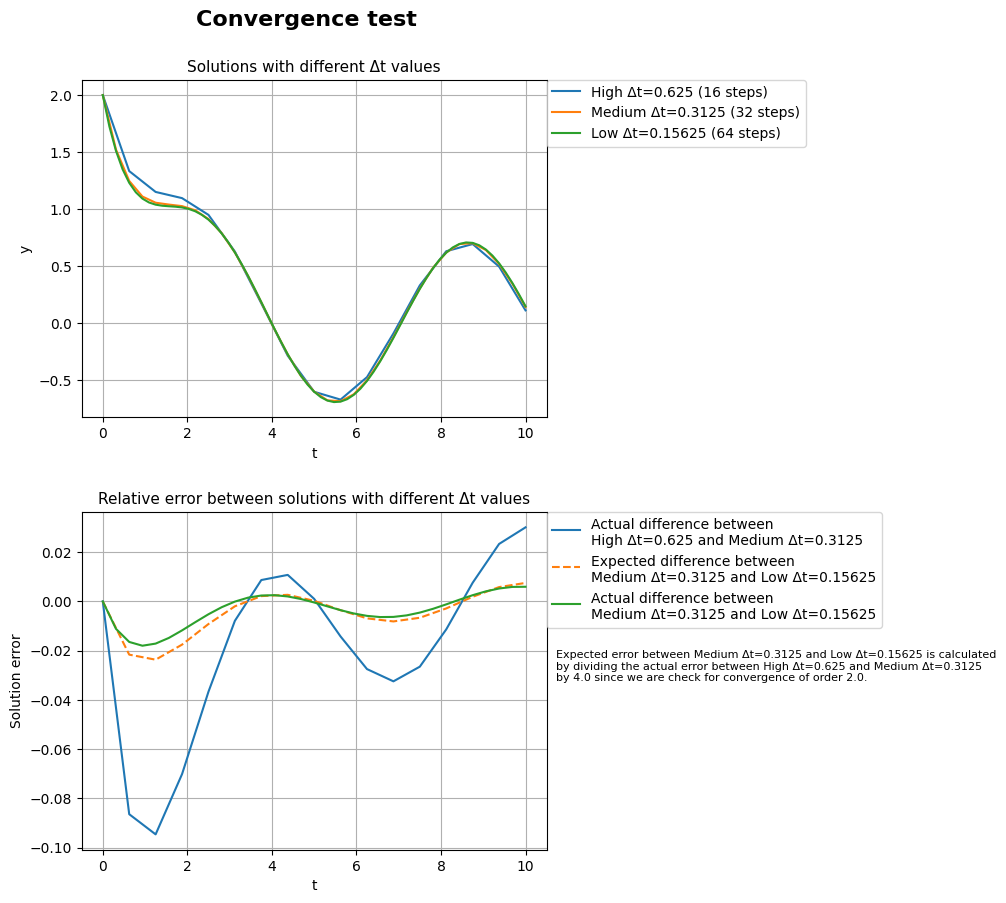

My implementation of midpoint method produces the same result.


In [35]:
example_convergence_test_from_week_4_lab(integration_function=Integrator.integrate_using_midpoint,
                                         get_values_to_compare_function=lambda sol: sol[0],
                                         to_str_function=lambda sol: str(sol[0]))
print("My implementation of midpoint method produces the same result.")

My implementation of the midpoint method also produces the expected results. Once again, the results from the above test shows that the midpoint method is of second order.

Let's run the convergence test again on the midpoint method, this time for the 3-body problem. We will use the initial conditions for the figure-8 orbit and run the test for the X-coordinate of the first star only.

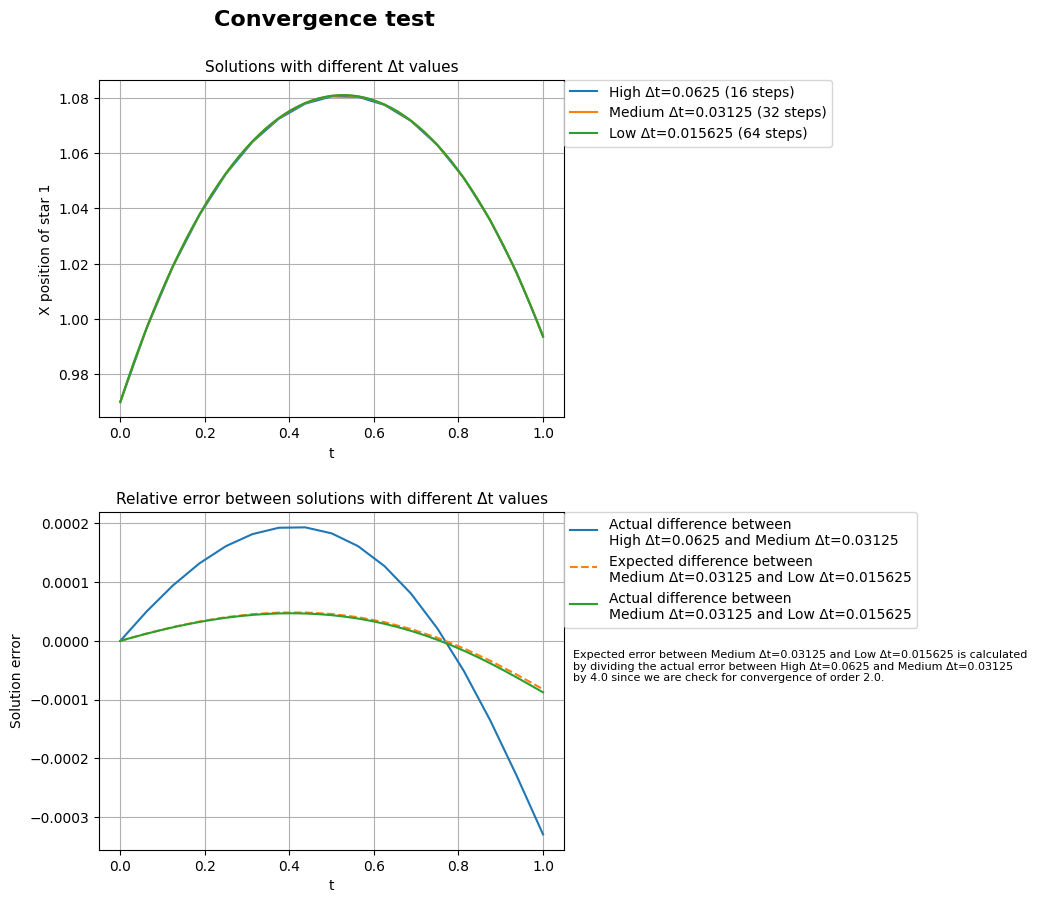

In [36]:
def example_convergence_test(scenario=get_prepared_scenarios('3_stars_stable_12T'), initial_N_steps=16, lifetime=1.0, method='Midpoint', expected_order=2.0):

    initial_stars = [
        Star(mass=scenario['masses'][i],
            position_vector=np.array([scenario['x_coords'][i], scenario['y_coords'][i]]),
            velocity_vector=np.array([scenario['vx_vels'][i], scenario['vy_vels'][i]])
        ) for i in range(scenario['N_stars'])
    ]

    system_of_stars_for_convergence_test = SystemOfStars(initial_stars=initial_stars)
    state = SystemOfStars.convert_stars_to_system_state_vector(initial_stars)
    test_convergence_and_plot(
        derivative_function=system_of_stars_for_convergence_test.compute_system_derivative_vector,
        initial_state=state,
        integration_function=Integrator.get_integration_function(method),
        get_values_to_compare_function=lambda sol: sol[0],
        value_to_compare_name='X position of star 1',
        to_str_function=lambda sol: '',
        expected_order=2.0,
        initial_N_steps=initial_N_steps,
        lifetime=lifetime,
    )
# derivative_function, initial_state, integration_function,
#                               get_values_to_compare_function, to_str_function,
#                               expected_order=2.0, value_to_compare_name='y',
#                               initial_N_steps : int=16, lifetime=DEFAULT_LIFETIME,
#                               returns_string=False, filename=None
example_convergence_test(
    scenario=get_prepared_scenarios('3_stars_stable_12T'),
    initial_N_steps=16,
    lifetime=1.0
)

Here the results also suggests the midpoint method is of second order, with the actual and expected differences between Medium and Low resolutions match each other really well. Note that here the lifetime is only up to $t=1.0$. Let's try to run the test for $t=8.0$. To keep $\Delta t$ the same, I will also multiply the numbers of timesteps by $8$.

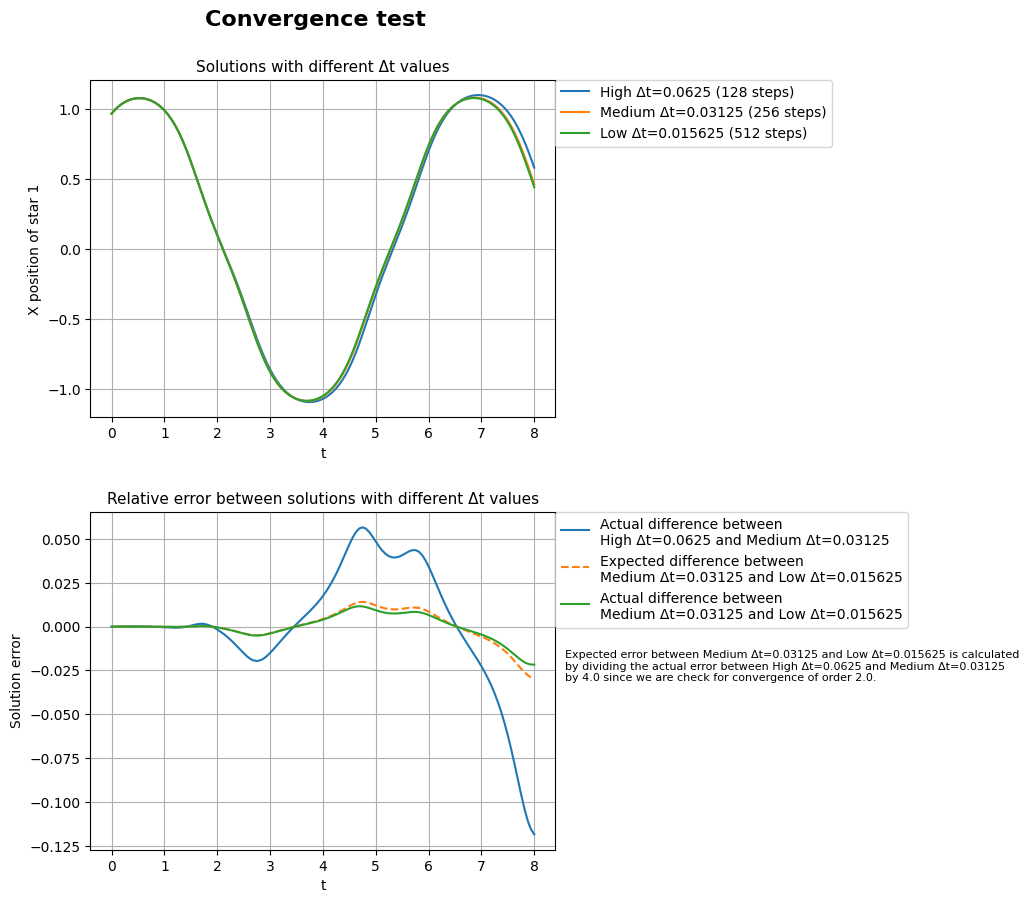

In [37]:
example_convergence_test(
    scenario=get_prepared_scenarios('3_stars_stable_12T'),
    initial_N_steps=128,
    lifetime=8.0
)

The actual and expected Medium-and-Low $\Delta t$ differences starts to diverge just a little bit, but it seems that, as the values obsilate, the actual difference is pulled back towards the expected level. How about $t=32.0$?

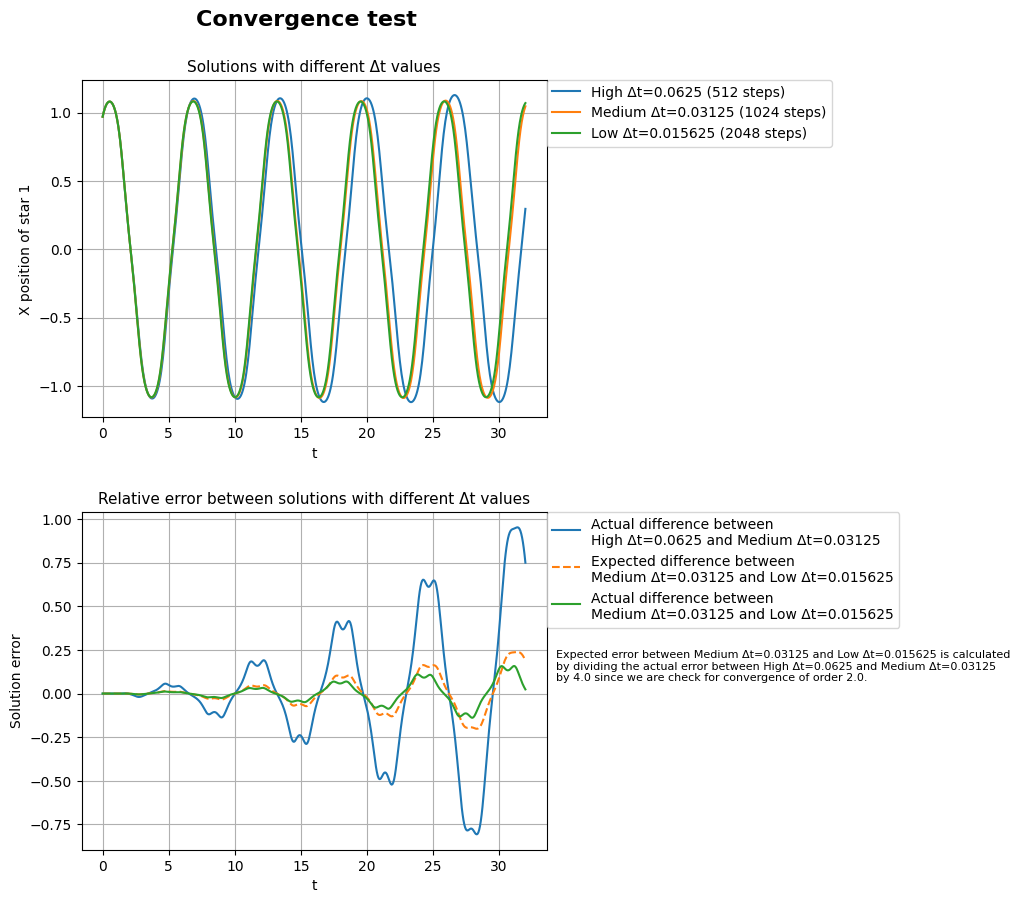

In [38]:
example_convergence_test(initial_N_steps=512, lifetime=32.0)

So we can see that even though the difference between the expected and actual errors fluctuate, the actual error still stays around the expected range. This is a strong indication that the midpoint method is indeed of second order. Also note that the errors increase as the time increases. This is expected as the numerical inaccuracies accumulate over time.

Let's run the test for RK45 method as well just for a quick comparison. Let's say we want to see whether the RK45 method is of fourth order.

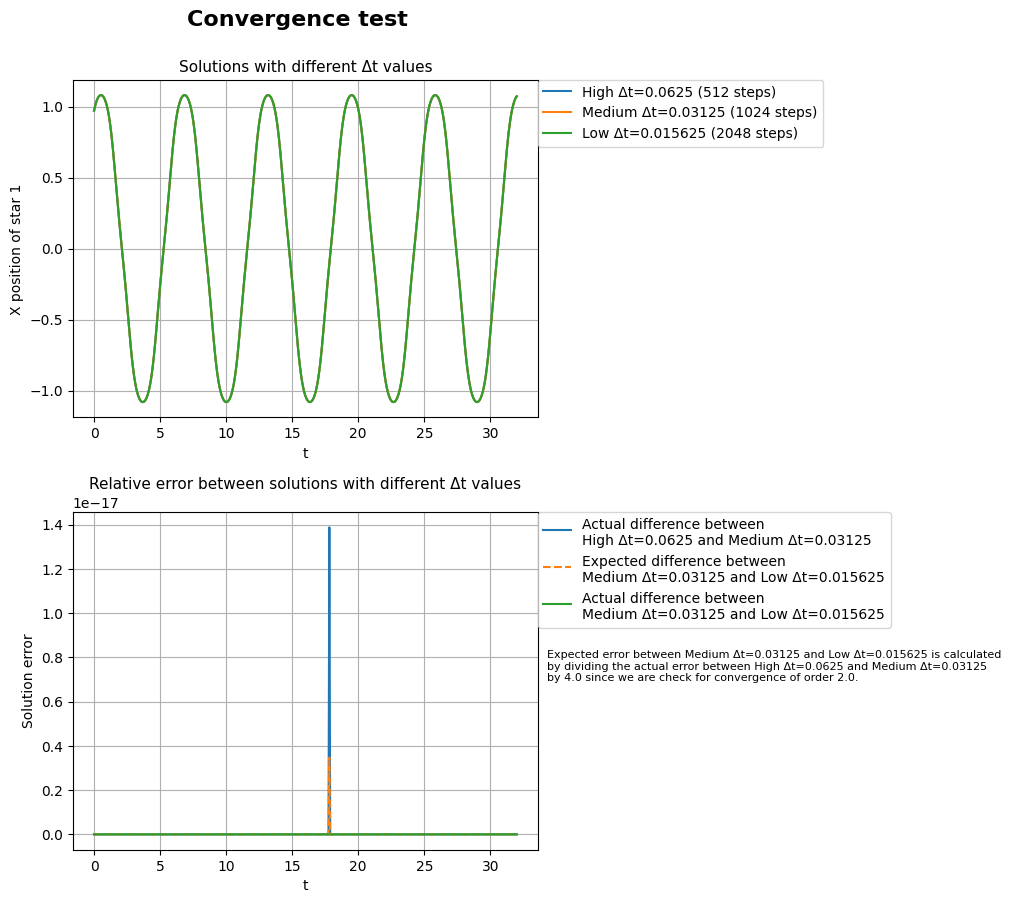

In [39]:
example_convergence_test(initial_N_steps=512, lifetime=32.0, method='RK45', expected_order=4.0)

For the same initial conditions, `solve_ivp`'s RK45 implementation is so much more accurate. The errors are so small that they are almost negligible (note how the error plot is actually of magnitude `1e-17`). Even just from looking at the plot of $X$-coordinate of the first star against time, we can already see that, while in the midpoint method case the lines no longer perfectly match up, here the lines are still almost indistinguishable.

<a id='doctests'></a>
## Run all `doctest`s to double check

The doctests should all pass. It is a good idea to run this cell at least once after all the code is finished.

In [40]:
doctest.testmod()
doctest.testmod(raise_on_error=True)

TestResults(failed=0, attempted=2)

## In progress - Working on Hypergiants and merging of Hypergiants

As can be seen in some previous simulations, for instance this [unstable three-body system](#three-body-unstable-system), stars can collide. What if instead of treating stars as points that simply pass through one another, we treat them as hypergiants that can merge together?

### `Hypergiant` class

First we could design a new class to represent a Hypergiant. We can do this by extending/inheriting from `Star` class, with the addition of a radius and some other useful attributes such as birth time and death time to mark the beginning of a new hypergiant after a collision or the end of the stars that have collided.

In [41]:
class Hypergiant(Star):

  MAX_POSSIBLE_TIMESTEP = int(1e10)

  def __init__(self, mass, position_vector, velocity_vector, index, birth_timestep:int=0):
    super().__init__(mass, position_vector, velocity_vector)
    self._birth_timestep = birth_timestep
    self._death_timestep = Hypergiant.MAX_POSSIBLE_TIMESTEP
    self.index = index

  @property
  def birth_timestep(self):
    return self._birth_timestep

  @birth_timestep.setter
  def birth_timestep(self, birth_timestep):
    assert birth_timestep >= 0, "Birth timestep must be greater than or equal to 0"
    self._birth_timestep = birth_timestep

  @property
  def death_timestep(self):
    return self._death_timestep

  @death_timestep.setter
  def death_timestep(self, death_time):
    assert death_time >= self.birth_time, "Death time must be greater than or equal to birth time"
    self._death_time = death_time

  @property
  def radius(self) -> float:
    return self.mass ** (1.0 / self.N_dimensions)     # 2D mass is proportional to area

  @property
  def centre_position_vector(self) -> np.ndarray:
    return self.position_vector

  def compute_distance_from_this_centre_to_the_other_centre(self, other_hypergiant):
    return self.compute_distance_to(other_hypergiant)

  def is_colliding_with(self, other_hypergiant) -> bool:
    distance_between_centres = self.compute_distance_from_this_centre_to_the_other_centre(other_hypergiant)
    return distance_between_centres <= self.radius + other_hypergiant.radius

  @property
  def product_of_mass_and_centre_position_vector(self) -> np.ndarray:
    return self.mass * self.centre_position_vector

  @property
  def product_of_mass_and_velocity_vector(self) -> np.ndarray:
    return self.mass * self.velocity_vector

  @property
  def first_moment_of_mass(self) -> np.ndarray:
    return self.product_of_mass_and_centre_position_vector

  @property
  def momentum(self) -> np.ndarray:
    return self.product_of_mass_and_velocity_vector

  def set_velocity(self, velocity_vector):
    self.vx, self.vy = velocity_vector

  def set_centre_position(self, centre_position_vector):
    self.x, self.y = centre_position_vector

  def set_mass(self, mass):
    self.mass = mass


In [42]:
def example_hypergiant():
    ex_hypergiant_0 = Hypergiant(
        mass=0.1,
        position_vector=np.array([0.0, 0.0]),
        velocity_vector=np.array([0.0, 0.0]),
        birth_timestep=0,
        index=0
    )
    print(type(ex_hypergiant_0))

example_hypergiant()

<class '__main__.Hypergiant'>


### `SystemOfHypergiants` class

Next we can customise our `SystemOfStars` class to make a new `SystemOfHypergiants` class, again by inheritance. Here we can make necessary adjustments to the ODE computation methods to include new logic for hypergiant collisions.

The idea is that, since we still have to use the same vector size for the integration method, especially if we want to make it suitable for `solve_ivp`, we can substitute in the new state for the new hypergiant in the same position as one of the previous stars that have collided. This way we can keep the vector size the same and still use the same integration method. The other stars that have merged will have their values on the vector as well as their masses set to zero.

In order to re-create the simulation, we need to keep track of the birth time of the new hypergiant and the death time of the stars that have merged. This way we can know when to stop plotting the old hypergiants and start plotting the new one. This is why we customise the `Star` class into the `Hypergiant` class as above.

Those are the main ideas. Now let's implement them.

(The code below is an attempt at this simulation and currently still a work in progress.)

In [43]:
class SystemOfHypergiants(SystemOfStars):

  def __init__(self, hypergiants):
    super().__init__(hypergiants)
    for (i, hypergiant) in enumerate(self.hypergiants):
      hypergiant.index = i
    self.N_hypergiants = len(hypergiants) # Same as N_stars. Naming for consistency.
    self._is_containing_hypergiant_at_index = {i: True for i in range(len(hypergiants))}
    self.colours = create_colours_equally_spaced_in_hue(len(hypergiants) * 2 - 1)
    self._to_state_vector_index = [i for i in range(self.N_hypergiants)]

  @property
  def hypergiants(self): return self.initial_stars

  def compute_ODE_component_of_this_hypergiant_by_other_hypergiant(
      self, this_hypergiant : Hypergiant, other_hypergiant_index : int) -> tuple:
    """
    Calculate the partial acceleration of this hypergiant
    due to the gravitational force from the other hypergiant.

    If the other hypergiant is already merged and removed from the list of hypergiants,
    return 0.0 for both components of the acceleration.
    """
    if self._is_containing_hypergiant_at_index[other_hypergiant_index]:
      other_hypergiant = self.hypergiants[other_hypergiant_index]
      second_order_derivative_component = \
        super.compute_ODE_component_of_this_star_by_other_star(this_hypergiant, other_hypergiant)
    else:
      # The other hypergiant does not exist. There is no effect from the other hypergiant.
      second_order_derivative_component = (0.0, 0.0)
    return second_order_derivative_component


  def convert_system_state_vector_to_stars(self, state_vector):
    """
    Convert a state vector to a list of hypergiants.
    """
    hypergiants_at_time_t = []
    for (index_in_our_list, hypergiant_at_time_0) in enumerate(self.hypergiants):
      if self._is_containing_hypergiant_at_index[index_in_our_list]:
        index_in_state_vector = self._to_state_vector_index[index_in_our_list]
        hypergiant_at_time_t = Hypergiant(
          mass=hypergiant_at_time_0.mass,
          position_vector=np.array([index_in_state_vector*4, index_in_state_vector*4+1]),
          velocity_vector=np.array([index_in_state_vector*4+2, index_in_state_vector*4+3]),
          birth_timestep=hypergiant_at_time_0.birth_timestep,
          index=index_in_our_list
        )
        hypergiants_at_time_t.append(hypergiant_at_time_t)
    return hypergiants_at_time_t


  def compute_derivative_for_a_star(self, hypergiants_at_time_t, index_in_state_vector) -> tuple:
    this_hypergiant = hypergiants_at_time_t[index_in_state_vector]
    if self._is_containing_hypergiant_at_index[this_hypergiant.index]:
      derivative_at_t = super().compute_derivative_for_a_star(hypergiants_at_time_t, index_in_state_vector)
    else:
      # This hypergiant does not exist.
      derivative_at_t = (0.0, 0.0, 0.0, 0.0)
    return derivative_at_t


  def check_for_collisions(self, hypergiants_at_time_t):
    """
    Check for collisions between hypergiants.

    Returns
    -------
    dict
        A dictionary of merge groups.
        The keys are the indices of the hypergiants that will remain in our system.
        The values are lists of indices of the hypergiants that are to be merged to the hypergiant at the key.
    """

    collision_groups = {}
    for (_, this_hypergiant) in enumerate(hypergiants_at_time_t, start=0):
      index_of_this_hypergiant_in_our_hypergiant_list = this_hypergiant.index
      i = index_of_this_hypergiant_in_our_hypergiant_list
      if self._is_containing_hypergiant_with_id[i] is False:
        continue

      collision_groups[i] = []
      for (_, other_hypergiant) in enumerate(hypergiants_at_time_t, start=i+1):
        index_of_other_hypergiant_in_our_hypergiant_list = other_hypergiant.index
        k = index_of_this_hypergiant_in_our_hypergiant_list
        if self._is_containing_hypergiant_with_id[k] is False:
          continue

        if this_hypergiant.is_colliding_with(other_hypergiant):
          self._is_containing_hypergiant_with_id[k] = False
          collision_groups[i].append(k)

      if len(collision_groups[i]) == 0:
        # No collision. Remove the empty list
        del collision_groups[i]
      else:
        # Add the current hypergiant to the collision group
        self._is_containing_hypergiant_with_id[i] = False
        collision_groups[i].append(i)

    return collision_groups



  def create_new_hypergiant_from_collision(self, hypergiants_at_time_t, collision_group_indices, current_timestep, i):
    total_mass = self.hypergiants[i].mass + \
      np.sum([self.hypergiants[k].mass for k in collision_group_indices])

    total_first_moment_of_mass = self.hypergiants[i].first_moment_of_mass + \
      np.sum([self.hypergiants[k].first_moment_of_mass for k in collision_group_indices])

    total_momentum = self.hypergiants[i].momentum + \
      np.sum([self.hypergiants[k].momentum for k in collision_group_indices])

    centre_of_mass = total_first_moment_of_mass / total_mass

    velocity_of_centre_of_mass = total_momentum / total_mass

    new_hypergiant = Hypergiant(
      mass=total_mass,
      x=centre_of_mass[0],
      y=centre_of_mass[1],
      vx=velocity_of_centre_of_mass[0],
      vy=velocity_of_centre_of_mass[1],
      birth_time=current_timestep,
    )
    return new_hypergiant




  def merge_hypergiants(self, hypergiants_at_time_t, collision_groups : dict, current_timestep):
    """
    Merge hypergiants that are colliding with one another.

    Assume perfectly inelastic collision
    """
    for (i_group_representative, collision_group) in collision_groups.items():
      i_new_hypergiant = len(self.hypergiants)  # The new hypergiant is the new last item in our list

      # Create the new hypergiant
      new_hypergiant = self.create_new_hypergiant_from_collision(hypergiants_at_time_t,
                                                                 collision_group,
                                                                 current_timestep,
                                                                 index=i_new_hypergiant)

      # Mark the new hypergiant as existing
      self._is_containing_hypergiant_with_id[new_hypergiant.index] = True

      # Add the new hypergiant to our list
      self.hypergiants.append(new_hypergiant)

      # Update back reference to the state vector so we know which values to plot
      self._to_state_vector_index.append(i_group_representative)



  def plot_trajectory(self, x_coords_of_all_stars, y_coords_of_all_stars, output, axis):
    for index_in_our_list in range(len(self.hypergiants)):
      birth = self.hypergiants[index_in_our_list].birth_timestep
      death = self.hypergiants[index_in_our_list].death_timestep
      index_in_state_vector = self._to_state_vector_index[index_in_our_list]
      x_coords = x_coords_of_all_stars[index_in_state_vector, birth:death]
      y_coords = y_coords_of_all_stars[index_in_state_vector, birth:death]
      super.plot_in_common_form(
        horizontal_values=x_coords,
        vertical_values=y_coords,

        horizontal_label='X Position',
        vertical_label='Y Position',

        title=f'Orbit of Hypergiants',
        output=output, axis=axis
      )

  def plot_graphs(self, sol, output_widget):
    with output_widget:
      output_widget.clear_output(wait=True)
      fig, axes = plt.subplots(3, 1, figsize=(8, 16))
      # increase the space between the subplots
      plt.subplots_adjust(hspace=0.4)  # hspace is the spacing between the subplots in figure units (0 = no space, 1 = the subplots fill the figure) (default: 0.2)

      x_coords = []
      y_coords = []
      vx_vels = []
      vy_vels = []
      for i in range(self.N_stars):
          x_coords.append(sol[i*4])
          y_coords.append(sol[i*4+1])
          vx_vels.append(sol[i*4+2])
          vy_vels.append(sol[i*4+3])

      self.plot_trajectory(x_coords, y_coords, output_widget, axes[0])

      # # Plot the phase plots
      # #  For each star, plot the x-velocity against the x-position
      # #  and the y-velocity against the y-position
      # self.plot_phase_plot_X(x_coords, vx_vels, output_widget, axes[1])
      # self.plot_phase_plot_Y(y_coords, vy_vels, output_widget, axes[2])

      plt.show();

### Plot System of Hypergiants

In [44]:
def example_plot_hypergiants():

    hypergiant_masses = [0.8, 1.0, 1.2]

    # Set initial conditions for collision
    hypergiant_x_coords =   [0.97000436,    -0.97000436,    0.0         ]
    hypergiant_y_coords =   [-0.24308753,   0.24308753,     0.0         ]
    hypergiant_vx_vels =    [-0.9,    0.1,     0.9 ]
    hypergiant_vy_vels =    [-0.9,          0.0,            0.2         ]

    hypergiants_in_initial_state = [
        Hypergiant(
            mass=hypergiant_mass,
            position_vector=np.array([hypergiant_x_coords[i], hypergiant_y_coords[i]]),
            velocity_vector=np.array([hypergiant_vx_vels[i], hypergiant_vy_vels[i]]),
            index=i
        )
        for (i, hypergiant_mass) in enumerate(hypergiant_masses)
    ]

    system_of_hypergiants = SystemOfHypergiants(hypergiants_in_initial_state)


    # Create a new Output widget to display the plot.
    output_widget = Output()


    # Create textboxes for user to enter parameters

    textboxes_to_input_mass, star_textboxes, lifetime_textbox, N_timesteps_textbox = \
        create_textboxes(stars=hypergiants_in_initial_state, lifetime=DEFAULT_LIFETIME, N_timesteps=DEFAULT_N_TIMESTEPS)



    # hypergiant_textboxes, lifetime_textbox, N_timesteps_textbox = create_textboxes(

        # hypergiants_in_initial_state, lifetime=DEFAULT_LIFETIME, N_timesteps=DEFAULT_N_TIMESTEPS)

    hypergiants_plot_arguments = pack_widgets_into_arguments_dict(
        textboxes_to_input_mass,
        star_textboxes,
        lifetime_textbox,
        N_timesteps_textbox
    )


    # Create a function to update the plot when textboxes are changed. To be used in `interactive`
    def update_hypergiants_plot(**kwargs):
        try:
            system_of_hypergiants.simulate_N_body_system(
                stars_in_initial_state=[
                    Star(
                        mass=hypergiant_mass,
                        x=float(kwargs.get(f'init_x{i+1}', hypergiant_x_coords[i])),
                        y=float(kwargs.get(f'init_y{i+1}', hypergiant_y_coords[i])),
                        vx=float(kwargs.get(f'init_vx{i+1}', hypergiant_vx_vels[i])),
                        vy=float(kwargs.get(f'init_vy{i+1}', hypergiant_vy_vels[i]))
                    )
                    for (i, hypergiant_mass) in enumerate(hypergiant_masses)
                ],
                lifetime=float(kwargs.get('t_span', 1000)),
                N_timesteps=int(kwargs.get('t_steps', 10000)),
                output_widget=output_widget
            )
        except Exception as e:
            with output_widget:
                output_widget.clear_output(wait=True)
                print(f"Error: {e}")



    # # Create the interactive plot
    # interactive_plot = interactive(update_hypergiants_plot, **hypergiants_plot_arguments)


    # # Display the interactive widget
    # display(interactive_plot)

    # # Display the Output widget containing the plot
    # display(output_widget)



    # TODO: Apparently this plot will be updated if user changes parameters in the previous plot!
    #       How to prevent this?


    lifetime=2.69
    N_timesteps=1000
    timepoints = np.linspace(0, lifetime, N_timesteps + 1)

    sol = Integrator.integrate_using_solve_ivp_RK45(
        system_of_hypergiants.compute_system_derivative_vector,
        SystemOfHypergiants.convert_stars_to_system_state_vector(hypergiants_in_initial_state),
        lifetime=lifetime,
        timepoints=timepoints
    )

    print(sol.shape)
    masses = [hypergiant.mass for hypergiant in system_of_hypergiants.hypergiants]
    colors = create_colours_equally_spaced_in_hue(len(system_of_hypergiants.hypergiants) * 2 - 1)
    def plot_in_common_form(system_of_hypergiants,
                            horizontal_values, vertical_values,
                            horizontal_label, vertical_label,
                            title, axis):
        N_hypergiants_to_plot = len(system_of_hypergiants.hypergiants)
        for i in range(N_hypergiants_to_plot):
            axis.plot(
                horizontal_values[i],
                vertical_values[i],
                # label=f'Star {i+1}, mass={masses[i]}',
                # label=f'{colour_names[i]} Star, mass={masses[i]}',
                color=colors[i]
            )
            axis.plot(
                horizontal_values[i][-1],
                vertical_values[i][-1],
                'o',
                label=f'Star {i+1}, mass={masses[i]}',
                color=colors[i],
                markersize=20
            )
            axis.set_xlabel(horizontal_label)
            axis.set_ylabel(vertical_label)
            axis.set_title(title)
            axis.legend(
                bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0,
                labelspacing=2.0,  # increase space between lines in legend
            )
            axis.grid(True)



    def plot_trajectory(system_of_hypergiants, x_coords_of_all_stars, y_coords_of_all_stars, axis):

        for index_in_our_list in range(len(system_of_hypergiants.hypergiants)):

            hypergiant = system_of_hypergiants.hypergiants[index_in_our_list]
            birth = hypergiant.birth_timestep
            death = hypergiant.death_timestep

            index_in_state_vector = system_of_hypergiants._to_state_vector_index[index_in_our_list]

            x_coords = x_coords_of_all_stars[index_in_state_vector][birth:death]
            y_coords = y_coords_of_all_stars[index_in_state_vector][birth:death]

            print(f'index_in_our_list={index_in_our_list}, index_in_state_vector={index_in_state_vector}, birth={birth}, death={death}')
            # print(f'x_coords.shape={x_coords.shape}')
            # print(f'y_coords.shape={y_coords.shape}')

            plot_in_common_form(
                system_of_hypergiants,
                horizontal_values=x_coords,
                vertical_values=y_coords,

                horizontal_label='X Position',
                vertical_label='Y Position',

                title=f'Orbit of Hypergiants',
                axis=axis
            )



    def plot_graphs(sol):
        fig, axes = plt.subplots(3, 1, figsize=(8, 16))
        # increase the space between the subplots
        plt.subplots_adjust(hspace=0.4)  # hspace is the spacing between the subplots in figure units (0 = no space, 1 = the subplots fill the figure) (default: 0.2)

        x_coords = []
        y_coords = []
        vx_vels = []
        vy_vels = []
        for i in range(system_of_hypergiants.N_stars):
            x_coords.append(sol[i*4])
            y_coords.append(sol[i*4+1])
            vx_vels.append(sol[i*4+2])
            vy_vels.append(sol[i*4+3])

        print(f'x_coords.shape={np.array(x_coords).shape}')
        plot_trajectory(system_of_hypergiants, x_coords, y_coords, axes[0])

        # # Plot the phase plots
        # #  For each star, plot the x-velocity against the x-position
        # #  and the y-velocity against the y-position
        # self.plot_phase_plot_X(x_coords, vx_vels, output_widget, axes[1])
        # self.plot_phase_plot_Y(y_coords, vy_vels, output_widget, axes[2])

        plt.show();

    plot_graphs(sol)

example_plot_hypergiants()

AssertionError: Elements of Position vector must be floats. Expected <class 'numpy.float64'>. Got int64

In [ ]:
# class SystemOfHypergiants(SystemOfStars):
#     def __init__(self, hypergiants):
#         super().__init__(hypergiants)

#     def check_for_mergers(self):
#         merged = []
#         for i in range(len(self.stars)):
#             for j in range(i + 1, len(self.stars)):
#                 if self._should_merge(self.stars[i], self.stars[j]):
#                     merged_hypergiant = self.stars[i].merge_with(self.stars[j])
#                     merged.append((i, j, merged_hypergiant))
#         return merged

#     def _should_merge(self, hypergiant1, hypergiant2):
#         distance = np.sqrt((hypergiant1.x - hypergiant2.x)**2 + (hypergiant1.y - hypergiant2.y)**2)
#         merge_distance = hypergiant1.radius + hypergiant2.radius  # or any other logic
#         return distance <= merge_distance

#     def update_after_mergers(self, mergers):
#         for i, j, merged_hypergiant in sorted(mergers, reverse=True):
#             # Remove the merged hypergiants
#             del self.stars[max(i, j)]
#             del self.stars[min(i, j)]
#             # Add the new merged hypergiant
#             self.stars.append(merged_hypergiant)

#     def update_state(self, new_state):
#         """
#         Update the state of the hypergiants in the system.

#         Parameters:
#         new_state (array): The new state array from the ODE solver.
#         """
#         for i in range(self.N_stars):
#             # Update position and velocity for each hypergiant
#             # self.stars[i].x = new_state[i*4]
#             # self.stars[i].y = new_state[i*4 + 1]
#             # self.stars[i].vx = new_state[i*4 + 2]
#             # self.stars[i].vy = new_state[i*4 + 3]
#             self.stars[i].x = new_state[i*2]
#             self.stars[i].y = new_state[i*2 + 1]
#             self.stars[i].vx = new_state[self.N_stars*2 + i*2]
#             self.stars[i].vy = new_state[self.N_stars*2 + i*2 + 1]

#     def calculate_center_of_mass(self):
#         """
#         Calculate the center of mass of the system.

#         Returns:
#         tuple: The coordinates (x, y) of the center of mass.
#         """
#         total_mass = 0
#         x_weighted_sum = 0
#         y_weighted_sum = 0

#         for hypergiant in self.stars:
#             total_mass += hypergiant.mass
#             x_weighted_sum += hypergiant.mass * hypergiant.x
#             y_weighted_sum += hypergiant.mass * hypergiant.y

#         if total_mass == 0:
#             return 0, 0  # Avoid division by zero

#         center_of_mass_x = x_weighted_sum / total_mass
#         center_of_mass_y = y_weighted_sum / total_mass

#         return center_of_mass_x, center_of_mass_y

In [ ]:
# pseudocode
# while simulation_not_ended:
#     simulate_one_step()
#     mergers = system.check_for_mergers()
#     if mergers:
#         system.update_after_mergers(mergers)


In [ ]:
def example_simulating_system_of_hypergiants():
  # Example of initializing hypergiants
  base_mass = 10.0  # Example base mass

  # Hypergiant 1 (0.8 * base_mass)
  x1, y1 = 0.0, 0.0  # Initial position
  vx1, vy1 = 0.0, 0.5  # Initial velocity

  # Hypergiant 2 (1.0 * base_mass)
  x2, y2 = 0, 50  # Initial position
  vx2, vy2 = -0.5, 0  # Initial velocity

#   # Hypergiant 3 (1.2 * base_mass)
#   x3, y3 = 50, 0  # Initial position
#   vx3, vy3 = 0, -0.5  # Initial velocity

#   N = 3
  N = 2

  simulation_not_ended = True

  # Create initial hypergiants
  hypergiants = [
    Hypergiant(base_mass * 0.8,
        position_vector=np.array([x1, y1]),
        velocity_vector=np.array([vx1, vy1]),
        birth_timestep=0,
        index=0),
    Hypergiant(base_mass * 1.0,
        position_vector=np.array([x2, y2]),
        velocity_vector=np.array([vx2, vy2]),
        birth_timestep=0,
        index=1),
    # Hypergiant(base_mass * 1.2,
    #     position_vector=np.array([x3, y3]),
    #     velocity_vector=np.array([vx3, vy3]),
    #     birth_timestep=0,
    #     index=2),
  ]

  # Initialize the system of hypergiants
  system = SystemOfHypergiants(hypergiants)


  print(system.stars)


  # Get initial state for the solver
  initial_state = SystemOfHypergiants.get_state(hypergiants)

  # Set time span for the simulation
  t_span = 1000  # Adjust as needed
  time_steps = 1000  # Number of time steps
  t_eval = np.linspace(0, t_span, time_steps)

  max_mergers = 1  # Stop after 1 merger, adjust as needed
  total_mergers = 0  # Counter for the number of mergers

  max_simulation_time = 1000  # Maximum simulation time
  current_time = 0  # Track the current simulation time

  max_distance_threshold = 100  # Maximum distance from the center of mass

  # Assuming you have N hypergiants
  # N = len(system.stars)
  trajectories = [[] for _ in range(N)]  # Create an empty list for each hypergiant


  # while simulation_not_ended:
  for t in t_eval:
      if not simulation_not_ended:
          break
      # Simulate one time step
      # For example, using solve_ivp with a very short time span
      sol = solve_ivp(
          SystemOfHypergiants.n_body, t_span=(t, t + t_span / time_steps), y0=initial_state,
          method='RK45', rtol=1e-9, atol=1e-6
      )

      # Update system state with the solution
      if sol.success:
          new_state = sol.y[:, -1]  # Get the state at the end of the time step
          system.update_state(new_state)
          initial_state = new_state  # Update initial state for the next step

      # Check for mergers
      mergers = system.check_for_mergers()
      if mergers:
          total_mergers += len(mergers)
          system.update_after_mergers(mergers)
          # Re-calculate the initial state after merger
          initial_state = SystemOfHypergiants.get_state(system.stars)

      # Check if the maximum number of mergers has been reached
      if total_mergers >= max_mergers:
          print("Ending simulation: Maximum number of mergers reached.")
          break

      # Update current simulation time
      current_time += t_span / time_steps

      # Check if maximum simulation time has been reached
      if current_time >= max_simulation_time:
          print("Ending simulation: Maximum simulation time reached.")
          break

      # Check if any hypergiant is too far from the center of mass
      center_of_mass = system.calculate_center_of_mass()
      for hypergiant in system.stars:
          distance = np.sqrt((hypergiant.x - center_of_mass[0])**2 + (hypergiant.y - center_of_mass[1])**2)
          if distance > max_distance_threshold:
              print("Ending simulation: A hypergiant is too far from the center of mass.")
              simulation_not_ended = False
              break

      # Update trajectories after each time step
      for i, hypergiant in enumerate(system.stars):
          trajectories[i].append((hypergiant.x, hypergiant.y))

  # Process or visualize the results

example_simulating_system_of_hypergiants()


In [ ]:
def example_plot_trajectories(trajectories):
    # Let's say trajectories is a list of lists,
    # where each sublist contains the (x, y) coordinates of a hypergiant at each time step

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the trajectories
    for i, trajectory in enumerate(trajectories):
        # Unpack the positions
        x_positions, y_positions = zip(*trajectory)

        # Plot the path of each hypergiant
        ax.plot(x_positions, y_positions, label=f'Hypergiant {i+1}')

        # Mark the starting and ending positions
        ax.plot(
            x_positions[0], y_positions[0], 'go',
            markersize=10
        )  # Start in green

        ax.plot(
            x_positions[-1], y_positions[-1], 'ro',
            markersize=10
        )  # End in red

    # Add labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Trajectories of Hypergiants')
    ax.legend()
    ax.grid(True)

    # Show the plot
    plt.show()

example_plot_trajectories()

In [ ]:
# import ipywidgets as widgets
# from IPython.display import display

# # # Function to create a text box widget
# # def create_textbox(value, description):
# #     return widgets.Text(value=str(value), description=description)

# # Function to create a text box widget with a specific layout
# def create_textbox(value, description, width='300px', description_width='150px'):
#     return widgets.Text(value=str(value), description=description,
#                         layout=widgets.Layout(width=width),
#                         style={'description_width': description_width})


# # Hypergiant 1
# x1_widget = create_textbox('-50', 'Hypergiant 1 X:')
# y1_widget = create_textbox('0', 'Hypergiant 1 Y:')
# vx1_widget = create_textbox('0', 'Hypergiant 1 VX:')
# vy1_widget = create_textbox('0.5', 'Hypergiant 1 VY:')

# # Hypergiant 2
# x2_widget = create_textbox('0', 'Hypergiant 2 X:')
# y2_widget = create_textbox('50', 'Hypergiant 2 Y:')
# vx2_widget = create_textbox('-0.5', 'Hypergiant 2 VX:')
# vy2_widget = create_textbox('0', 'Hypergiant 2 VY:')

# # # Hypergiant 3
# # x3_widget = create_textbox('50', 'Hypergiant 3 X:')
# # y3_widget = create_textbox('0', 'Hypergiant 3 Y:')
# # vx3_widget = create_textbox('0', 'Hypergiant 3 VX:')
# # vy3_widget = create_textbox('-0.5', 'Hypergiant 3 VY:')

# # Display the widgets
# textboxes_widgets = widgets.VBox([
#   x1_widget, y1_widget, vx1_widget, vy1_widget,
#   x2_widget, y2_widget, vx2_widget, vy2_widget,
#   # x3_widget, y3_widget, vx3_widget, vy3_widget
# ])

# # Create an Output widget to display the plot
# output = Output()


# # Function to handle button click event
# def on_button_clicked(b):
#     # Read values from text boxes
#     x1 = float(x1_widget.value)
#     y1 = float(y1_widget.value)
#     vx1 = float(vx1_widget.value)
#     vy1 = float(vy1_widget.value)

#     x2 = float(x2_widget.value)
#     y2 = float(y2_widget.value)
#     vx2 = float(vx2_widget.value)
#     vy2 = float(vy2_widget.value)

#     # x3 = float(x3_widget.value)
#     # y3 = float(y3_widget.value)
#     # vx3 = float(vx3_widget.value)
#     # vy3 = float(vy3_widget.value)

#     # Start simulation with these values
#     # [Your simulation code goes here, using the above values]


#     # Assuming you have a way to determine when to end the simulation
#     simulation_not_ended = True

#     # Create initial hypergiants
#     hypergiants = [
#         Hypergiant(base_mass * 0.8, x1, y1, vx1, vy1),
#         Hypergiant(base_mass * 1.0, x2, y2, vx2, vy2),
#         # Hypergiant(base_mass * 1.2, x3, y3, vx3, vy3)
#     ]

#     # Initialize the system of hypergiants
#     system = SystemOfHypergiants(hypergiants)


#     print(system.stars)


#     # Get initial state for the solver
#     initial_state = SystemOfHypergiants.get_state(hypergiants)

#     # Set time span for the simulation
#     t_span = 1000  # Adjust as needed
#     time_steps = 1000  # Number of time steps
#     t_eval = np.linspace(0, t_span, time_steps)

#     max_mergers = 1  # Stop after 1 merger, adjust as needed
#     total_mergers = 0  # Counter for the number of mergers

#     max_simulation_time = 1000  # Maximum simulation time
#     current_time = 0  # Track the current simulation time

#     max_distance_threshold = 100  # Maximum distance from the center of mass

#     # Assuming you have N hypergiants
#     # N = len(system.stars)
#     trajectories = [[] for _ in range(N)]  # Create an empty list for each hypergiant


#     # while simulation_not_ended:
#     for t in t_eval:
#         if not simulation_not_ended:
#             break
#         # Simulate one time step
#         # This could be a call to your ODE solver for the next time step
#         # For example, using solve_ivp with a very short time span
#         sol = solve_ivp(
#             SystemOfHypergiants.n_body, t_span=(t, t + t_span / time_steps), y0=initial_state,
#             method='RK45', rtol=1e-9, atol=1e-6
#         )

#         # Update system state with the solution
#         if sol.success:
#             new_state = sol.y[:, -1]  # Get the state at the end of the time step
#             system.update_state(new_state)
#             initial_state = new_state  # Update initial state for the next step

#         # Check for mergers
#         mergers = system.check_for_mergers()
#         if mergers:
#             total_mergers += len(mergers)
#             system.update_after_mergers(mergers)
#             # Re-calculate the initial state after merger
#             initial_state = SystemOfHypergiants.get_state(system.stars)

#         # Check if the maximum number of mergers has been reached
#         if total_mergers >= max_mergers:
#             print("Ending simulation: Maximum number of mergers reached.")
#             break

#         # Update current simulation time
#         current_time += t_span / time_steps

#         # Check if maximum simulation time has been reached
#         if current_time >= max_simulation_time:
#             print("Ending simulation: Maximum simulation time reached.")
#             break

#         # Check if any hypergiant is too far from the center of mass
#         center_of_mass = system.calculate_center_of_mass()
#         for hypergiant in system.stars:
#             distance = np.sqrt((hypergiant.x - center_of_mass[0])**2 + (hypergiant.y - center_of_mass[1])**2)
#             if distance > max_distance_threshold:
#                 print("Ending simulation: A hypergiant is too far from the center of mass.")
#                 simulation_not_ended = False
#                 break

#         # Update trajectories after each time step
#         for i, hypergiant in enumerate(system.stars):
#             trajectories[i].append((hypergiant.x, hypergiant.y))

#     # Process or visualize the results

#     # Assuming you have recorded the positions of each hypergiant at each time step
#     # Let's say trajectories is a list of lists, where each sublist contains the (x, y) coordinates of a hypergiant at each time step
#     with output:
#         output.clear_output(wait=True)
#         # Create a figure and axis for the plot
#         fig, ax = plt.subplots(figsize=(10, 10))

#         # Plot the trajectories
#         for i, trajectory in enumerate(trajectories):
#             # Unpack the positions
#             x_positions, y_positions = zip(*trajectory)

#             # Plot the path of each hypergiant
#             ax.plot(x_positions, y_positions, label=f'Hypergiant {i+1}')

#             # Mark the starting and ending positions
#             ax.plot(
#                 x_positions[0], y_positions[0], 'go',
#                 markersize=10
#             )  # Start in green

#             ax.plot(
#                 x_positions[-1], y_positions[-1], 'ro',
#                 markersize=10
#             )  # End in red

#         # Add labels and title
#         ax.set_xlabel('X Position')
#         ax.set_ylabel('Y Position')
#         ax.set_title('Trajectories of Hypergiants')
#         ax.legend()
#         ax.grid(True)

#         # Show the plot
#         plt.show()

# # Create a button for starting the simulation
# button = widgets.Button(description="Start Simulation")
# button.on_click(on_button_clicked)

# # Display the button
# display(textboxes_widgets, button)


# display(output)


In [ ]:
# from matplotlib.animation import FuncAnimation

# class Hypergiant:
#     def __init__(self, mass, position, velocity):
#         self.mass = mass
#         self.position = np.array(position)
#         self.velocity = np.array(velocity)

#     def update_position(self, dt):
#         self.position += self.velocity * dt

# # Initial Conditions
# masses = [0.8, 1.0, 1.2]
# positions = [[-1, 0], [0, 0], [1, 0]]  # Customize these based on your simulation needs
# velocities = [[0, -1], [0, 0], [0, 1]]  # Customize these based on your simulation needs

# # Create Hypergiants
# hypergiants = [Hypergiant(m, p, v) for m, p, v in zip(masses, positions, velocities)]

# def merge_hypergiants(hg1, hg2):
#     new_mass = hg1.mass + hg2.mass
#     new_velocity = (hg1.mass * hg1.velocity + hg2.mass * hg2.velocity) / new_mass
#     return Hypergiant(new_mass, hg1.position, new_velocity)

# def simulation_step(dt):
#     global hypergiants
#     for hg in hypergiants:
#         hg.update_position(dt)

#     # Check for mergers
#     for i in range(len(hypergiants)):
#         for j in range(i+1, len(hypergiants)):
#             distance = np.linalg.norm(hypergiants[i].position - hypergiants[j].position)
#             if distance < (0.5 * (hypergiants[i].mass + hypergiants[j].mass)):  # Customize merge criteria
#                 hypergiants[i] = merge_hypergiants(hypergiants[i], hypergiants[j])
#                 del hypergiants[j]
#                 return

# # Visualization
# fig, ax = plt.subplots()
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)

# points, = ax.plot([], [], 'bo')

# def init():
#     points.set_data([], [])
#     return points,

# def animate(frame):
#     simulation_step(0.1)  # Adjust time step as needed
#     x = [hg.position[0] for hg in hypergiants]
#     y = [hg.position[1] for hg in hypergiants]
#     points.set_data(x, y)
#     return points,

# ani = FuncAnimation(fig, animate, frames=100, init_func=init, blit=True, interval=20)
# plt.show()


In [ ]:
# import plotly.express as px
# import pandas as pd

# class Hypergiant:
#     def __init__(self, mass, position, velocity):
#         self.mass = mass
#         self.position = np.array(position)
#         self.velocity = np.array(velocity)

#     def update_position(self, dt):
#         self.position += self.velocity * dt

# # Initial Conditions
# masses = [0.8, 1.0, 1.2]
# positions = [[-1, 0], [0, 0], [1, 0]]  # Customize these based on your simulation needs
# velocities = [[0, -1], [0, 0], [0, 1]]  # Customize these based on your simulation needs

# # Create Hypergiants
# hypergiants = [Hypergiant(m, p, v) for m, p, v in zip(masses, positions, velocities)]

# def merge_hypergiants(hg1, hg2):
#     new_mass = hg1.mass + hg2.mass
#     new_velocity = (hg1.mass * hg1.velocity + hg2.mass * hg2.velocity) / new_mass
#     return Hypergiant(new_mass, hg1.position, new_velocity)

# def simulation_step(dt):
#     global hypergiants
#     for hg in hypergiants:
#         hg.update_position(dt)

#     # Check for mergers
#     for i in range(len(hypergiants)):
#         for j in range(i+1, len(hypergiants)):
#             distance = np.linalg.norm(hypergiants[i].position - hypergiants[j].position)
#             if distance < (0.5 * (hypergiants[i].mass + hypergiants[j].mass)):  # Customize merge criteria
#                 hypergiants[i] = merge_hypergiants(hypergiants[i], hypergiants[j])
#                 del hypergiants[j]
#                 return True
#     return False

# # Run the simulation and store positions
# positions_data = []
# for step in range(1000):  # Number of simulation steps
#     positions_data.append([(hg.mass, hg.position[0], hg.position[1]) for hg in hypergiants])
#     # if simulation_step(0.1):  # Adjust time step as needed
#     if simulation_step(1):  # Adjust time step as needed
#         break

# # Convert to DataFrame for Plotly
# df = pd.DataFrame([{'step': step, 'mass': mass, 'x': x, 'y': y}
#                    for step, positions in enumerate(positions_data)
#                    for mass, x, y in positions])

# # Plotting
# fig = px.scatter(df, x='x', y='y', animation_frame='step', color='mass', size='mass',
#                  range_x=[-2, 2], range_y=[-2, 2], title='Hypergiant Orbits')
# fig.show()


In [ ]:
# class Hypergiant:
#     def __init__(self, mass, position, velocity):
#         self.mass = float(mass)
#         self.position = np.array(position).astype(float)
#         self.velocity = np.array(velocity).astype(float)

#     def update_position(self, dt):
#         self.position += self.velocity * dt

# # Initial Conditions
# masses = [0.8, 1.0, 1.2]
# positions = [[-1, 0], [0, 0], [1, 0]]  # Customize these based on your simulation needs
# velocities = [[0, -1], [0, 0], [0, 1]]  # Customize these based on your simulation needs

# # Create Hypergiants
# hypergiants = [Hypergiant(m, p, v) for m, p, v in zip(masses, positions, velocities)]

# def merge_hypergiants(hg1, hg2):
#     new_mass = hg1.mass + hg2.mass
#     new_velocity = (hg1.mass * hg1.velocity + hg2.mass * hg2.velocity) / new_mass
#     return Hypergiant(new_mass, hg1.position, new_velocity)

# def simulation_step(dt):
#     global hypergiants
#     for hg in hypergiants:
#         hg.update_position(dt)

#     # Check for mergers
#     for i in range(len(hypergiants)):
#         for j in range(i+1, len(hypergiants)):
#             distance = np.linalg.norm(hypergiants[i].position - hypergiants[j].position)
#             if distance < (0.5 * (hypergiants[i].mass + hypergiants[j].mass)):  # Customize merge criteria
#                 hypergiants[i] = merge_hypergiants(hypergiants[i], hypergiants[j])
#                 del hypergiants[j]
#                 return True
#     return False

# # Run the simulation and store positions
# positions_data = {i: [] for i in range(len(hypergiants))}
# for step in range(1000):  # Number of simulation steps
#     for i, hg in enumerate(hypergiants):
#         positions_data[i].append(hg.position.copy())
#     if simulation_step(10):  # Adjust time step as needed
#         break

# # Plotting
# plt.figure(figsize=(8, 6))
# for i, positions in positions_data.items():
#     positions = np.array(positions)
#     plt.plot(positions[:, 0], positions[:, 1], label=f'Hypergiant {i+1}',
#     marker='o', markersize=10)

# plt.xlabel('X Position')
# plt.ylabel('Y Position')
# plt.title('Trajectories of Hypergiants')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# class Hypergiant:
#     def __init__(self, mass, position, velocity):
#         self.mass = float(mass)
#         self.position = np.array(position).astype(float)
#         self.velocity = np.array(velocity).astype(float)

#     def update_position(self, dt):
#         # self.position += self.velocity * dt


# # Initial Conditions
# masses = [0.8, 1.0, 1.2]  # Masses of the hypergiants
# positions = [[-1, 0], [1, 0], [0, 2]]  # Initial positions
# velocities = [[0, -1], [0, 1], [-1, 0]]  # Initial velocities

# # Create Hypergiants
# hypergiants = [Hypergiant(m, p, v) for m, p, v in zip(masses, positions, velocities)]

# def merge_hypergiants(hg1, hg2):
#     new_mass = hg1.mass + hg2.mass
#     new_velocity = (hg1.mass * hg1.velocity + hg2.mass * hg2.velocity) / new_mass
#     return Hypergiant(new_mass, hg1.position, new_velocity)

# def simulation_step(dt):
#     global hypergiants
#     for hg in hypergiants:
#         hg.update_position(dt)

#     # Check for mergers
#     for i in range(len(hypergiants)):
#         for j in range(i+1, len(hypergiants)):
#             distance = np.linalg.norm(hypergiants[i].position - hypergiants[j].position)
#             if distance < (0.5 * (hypergiants[i].mass + hypergiants[j].mass)):  # Customize merge criteria
#                 hypergiants[i] = merge_hypergiants(hypergiants[i], hypergiants[j])
#                 del hypergiants[j]
#                 return True
#     return False

# # Run the simulation and store positions
# positions_data = {i: [] for i in range(len(hypergiants))}
# for step in range(500):  # Number of simulation steps
#     for i, hg in enumerate(hypergiants):
#         positions_data[i].append(hg.position.copy())
#     if simulation_step(5):  # Adjust time step as needed
#         break

# # Plotting
# plt.figure(figsize=(8, 6))
# for i, positions in positions_data.items():
#     positions = np.array(positions)
#     plt.plot(positions[:, 0], positions[:, 1], label=f'Hypergiant {i+1}')

# plt.xlabel('X Position')
# plt.ylabel('Y Position')
# plt.title('Trajectories of Hypergiants')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# class SystemOfHypergiants(SystemOfStars):
#   def ODE(stars, i: int) -> tuple:
#     dvx_dt = 0.0
#     dvy_dt = 0.0
#     merged = False
#     for j in range(len(stars)):
#       if i == j: continue
#       distance = np.sqrt((stars[i].x - stars[j].x)**2 + (stars[i].y - stars[j].y)**2)
#       if distance < (stars[i].radius + stars[j].radius):
#         merged = True
#         break
#       add_dvx_dt, add_dvy_dt = SystemOfStars.compute_ODE_component_of_this_star_by_other_star(stars[i], stars[j])
#       dvx_dt += add_dvx_dt
#       dvy_dt += add_dvy_dt
#     return dvx_dt, dvy_dt, merged



#   def n_body_helper(stars):
#     sol_dx_dt = []
#     sol_dy_dt = []

#     sol_dvx_dt = []
#     sol_dvy_dt = []

#     for i in range(len(stars)):
#       dx_i_dt = stars[i].vx
#       dy_i_dt = stars[i].vy
#       dvx_i_dt, dvy_i_dt, merged = SystemOfStars.ODE(stars, i)
#       if merged:
#           # Merge logic here

#           # Calculate new mass, position, and velocity

#           pass
#       sol_dx_dt.append(dx_i_dt)
#       sol_dy_dt.append(dy_i_dt)

#       sol_dvx_dt.append(dvx_i_dt)
#       sol_dvy_dt.append(dvy_i_dt)

#     sol = []
#     for i in range(N):
#       sol.append(sol_dx_dt[i])
#       sol.append(sol_dy_dt[i])

#     for i in range(N):
#       sol.append(sol_dvx_dt[i])
#       sol.append(sol_dvy_dt[i])

#     return np.array(sol)

